In [91]:
# import argparse
# import glob
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import pickle
# from sklearn.preprocessing import quantile_transform as qt
# import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
# from statsmodels.stats.multitest import fdrcorrection as fdr
# from scipy import stats

In [50]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def loadTRMat():
    with open("/scratch2/tsungyul/pm570/output/vntr/normedGenotype.pickle", 'rb') as f:
        trMat, tmMask = pickle.load(f)
#     with open("/scratch2/tsungyul/pm570/output/snp/normedGenotype.pickle", 'rb') as f:
#         snpMat, smMask = pickle.load(f)
    return trMat, tmMask #, snpMat, smMask

def loadSNPMat_index():
    tis2snpMat = {}
    for tissue in np.loadtxt("/scratch2/tsungyul/pm570/input/tissue.txt", dtype=object):
        mat = np.loadtxt(f"/scratch2/tsungyul/pm570/input/{tissue}.snp.gt.tsv", dtype=object)
        snpMat = mat[:,1:].astype(float)
        smMask = snpMat != 3
        snps = mat[:,0]
        snp2i = {}
        for i, snp in enumerate(snps):
            snp2i[snp] = i
        tis2snpMat[tissue] = [snpMat,smMask,snps,snp2i]
    return tis2snpMat

def loadSampleMask():
    ts = np.loadtxt("/scratch2/tsungyul/pm570/input/vntr.samples.txt", dtype=object)
    js = np.loadtxt("/scratch2/tsungyul/pm570/input/joint.samples.txt", dtype=object)
    return np.isin(ts, js)

def loadSNPPCinfo(ndim = 838):
    tmp = np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/gtex/variation/joint.pca.evec", usecols=np.arange(11), dtype=object)[:ndim] # XXX
    SNP_PCs = tmp[:,1:].astype(float)
    return SNP_PCs

def indexTR():
    trs = ["_".join(v) for v in np.loadtxt("/scratch2/tsungyul/pm570/input/clinic_29k.bed", dtype=object, usecols=[0,1,2])]
    tr2i = {}
    for i, tr in enumerate(trs):
        tr2i[tr] = i
    return trs, tr2i

In [94]:
def getTissueSampleMask(tissue):
    tmp = np.loadtxt(f'/home/cmb-17/mjc/vntr_genotyping/gtex/eqtl/input/GTEx_Analysis_v8_eQTL_expression_matrices/{tissue}.v8.normalized_expression.bed.gz', dtype=object, max_rows=1, comments="!")[4:]
    tisSampleList = np.array([s[5:] for s in tmp])        
    return np.isin(jgs, tisSampleList)

def loadTisResTpmMat(tissue):
    with open(f'/scratch2/tsungyul/pm570/ResMat//{tissue}.ResMat.pickle', 'rb') as f:
        tisResTpmMat = pickle.load(f)
    return tisResTpmMat

def indexGeneList(tissue):
    ges = np.loadtxt(f'/home/cmb-17/mjc/vntr_genotyping/gtex/eqtl/input/GTEx_Analysis_v8_eQTL_expression_matrices/{tissue}.v8.normalized_expression.bed.gz', dtype=object, skiprows=1, usecols=[3])
    ge2i = {}
    for i, ge in enumerate(ges):
        ge2i[ge] = i   
    return ges, ge2i

def loadJointeGene(tissue):
    esnptbl = np.loadtxt(f"/scratch2/tsungyul/pm570/input/{tissue}.v8.joint_egenes.esnp.txt", dtype=object, usecols=[0,11])
    etrtbl = np.loadtxt(f"/scratch2/tsungyul/pm570/output/vntr/{tissue}.v8.egenes.txt", dtype=object, usecols=[0,6,7,8])
    assert esnptbl.shape[0] == etrtbl.shape[0]
    n = esnptbl.shape[0]
    sp = esnptbl # SNP pair: eGene, eSNP
    tp = np.full([n,2], None, dtype=object) # TR pair: eGene, eTR
    for i in range(n):
        tp[i,0] = etrtbl[i,0]
        tp[i,1] = "_".join(etrtbl[i,1:])
    eg2spi, eg2tpi = {}, {}
    for i in range(n):
        eg2spi[sp[i,0]] = i
        eg2tpi[tp[i,0]] = i
    return sp, tp, eg2spi, eg2tpi

def runAssociation(tissue, vis=0):
    n = len(eg2spi)
    ps = np.full([n,2], np.nan)
    bs = np.full([n,2], np.nan)
    r2 = np.full([n,12], np.nan)
    for idx, (eg, _) in enumerate(esp):
        gei = ge2i[eg]
        y_ = tpmMat[gei]
        
        # simple linear regression
        spi = eg2spi[eg]
        snp = esp[spi][1]
        if snp not in tis2snpMat[tissue][3]: # tis2snpMat = {tis: [GT_matrix, mask, SNP_id, SNP_id_to_index]}
            #print(f"{tissue} lead SNP {snp} for {eg} not within 100kb range")
            continue
        snpi = tis2snpMat[tissue][3][snp]
        ysnp = y_[tsmMask[snpi]]
        xs_ = tsnpMat[snpi]
        xsnp = xs_[tsmMask[snpi]]
        x = (xsnp - np.mean(xsnp)) / np.std(xsnp)
        results = sm.OLS(ysnp, sm.add_constant(x[:,None])).fit()
        r2s = results.rsquared
        
        tpi = eg2tpi[eg]
        tr = etp[tpi][1]
        tri = tr2i[tr]
        ytr = y_[ttmMask[tri]]
        xt_ = ttrMat[tri]
        xtr = xt_[ttmMask[tri]]
        
        # multiple linear regression
        jm = np.logical_and(tsmMask[snpi], ttmMask[tri])# joint mask
        x = np.hstack((xs_[jm,None],xt_[jm,None]))
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        y = y_[jm]
        results = sm.OLS(y, sm.add_constant(x)).fit()
        r2m = results.rsquared
        p = results.pvalues[1:]
        b = results.params[1:]
        ps[idx] = [p[0],p[1]]
        bs[idx] = [b[0],b[1]]
        # simulate null hypothesis samples
        r2n = []
        for i in range(10):
            x = np.hstack((x[:,[0]], np.random.normal(size=x.shape[0])[:,None]))
            results = sm.OLS(y, sm.add_constant(x)).fit()
            r2n.append(results.rsquared)
        r2[idx] = [r2s,r2m] + r2n
        
        if vis >= 2:
            print(f"{eg}")
            if eg == "ENSG00000189306.10":
                x = np.hstack((xs_[jm,None],xt_[jm,None]))
                x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
                y = y_[jm]
                df = pd.DataFrame()
                df["snp"] = x[:,0]
                df["tr"] = x[:,1]
                df["y"] = y
                results = ols('y ~ snp + tr', data=df).fit()
                adf = sm.stats.anova_lm(results, typ=2)
                var = sum(adf["sum_sq"]) / sum(adf["df"])
#                 rsnp = 
#                 rtr
                
#             sum_sq     df           F        PR(>F)
# snp        17.295751    1.0   73.961860  1.396235e-16
# vntr       30.163884    1.0  128.989883  2.099772e-26
# Residual  103.360328  442.0         NaN           NaN
                
                fig, axes = plt.subplots(1,2,figsize=(8,3.5),dpi=200)
                axes[0].plot(xsnp, ysnp, '.k', alpha=0.3)
                axes[0].set_xlabel("SNP dosage")
                axes[0].set_ylabel("Residualized expression")
                axes[0].set_title(f"{snp.split('_')[:2]}")
                axes[1].plot(xtr, ytr, '.k', alpha=0.3)
                axes[1].set_xlabel("TR dosage")
                axes[1].set_title(f"{tr}")
                plt.show(); plt.close()
        
    r2dm, r2dsd = [], [] # r2_difference_mean, r2_difference_std
    for i in range(10):
        r2dm.append(np.nanmean(r2[:,i+2]-r2[:,0]))
        r2dsd.append(np.nanstd(r2[:,i+2]-r2[:,0]))
    r2dsd = np.nanmean(r2dsd)
    r2dm = np.nanmean(r2dm)
    sigi = np.nonzero((r2[:,1]-r2[:,0]-r2dm) > 3*r2dsd)[0] # significant index
    print(f"{sigi.size} {r2dm} {r2dsd}")
    
    if vis >= 1:
        if vis >= 2:
            plt.plot(np.log(ps[:,0]), np.log(ps[:,1]), '.k')
            plt.axis('equal')
            plt.show(); plt.close()
            plt.plot(bs[:,0], bs[:,1], '.k')
            plt.axis('equal')
            plt.show(); plt.close()
        plt.plot(r2[:,0], r2[:,1], '.k')
        plt.axis('equal')
        plt.show(); plt.close()
        
    return sigi.astype(int), r2[:,:2], ps, bs

def reportSignificantPairs(tissue):
    sigg = esp[sigi,0]
    sigsnp = np.full(sigg.size, None, dtype=object)
    sigtr = np.full(sigg.size, None, dtype=object)
    for i, (pi, ge) in enumerate(zip(sigi,sigg)):
        spi = eg2spi[ge]
        tpi = eg2tpi[ge]
        sigsnp[i] = esp[spi,1]
        sigtr[i] = etp[tpi,1]
    df = pd.DataFrame()
    df["gene"] = sigg
    df["snp"] = sigsnp
    df["tr"] = sigtr
    df["snp.r2"] = r2[sigi,0]
    df["joint.r2"] = r2[sigi,1]
    df["joint.beta.snp"] = bs[sigi,0]
    df["joint.beta.tr"] = bs[sigi,1]
    df["joint.pval.snp"] = ps[sigi,0]
    df["joint.pval.tr"] = ps[sigi,1]
    df["snp.r2"] = df["snp.r2"].map(lambda x: f"{x:.4f}")
    df["joint.r2"] = df["joint.r2"].map(lambda x: f"{x:.4f}")
    df["joint.beta.snp"] = df["joint.beta.snp"].map(lambda x: f"{x:.4f}")
    df["joint.beta.tr"] = df["joint.beta.tr"].map(lambda x: f"{x:.4f}")
    df["joint.pval.snp"] = df["joint.pval.snp"].map(lambda x: f"{x:.2e}")
    df["joint.pval.tr"] = df["joint.pval.tr"].map(lambda x: f"{x:.2e}")
    df.to_csv(f"/scratch2/tsungyul/pm570/output/{tissue}.significant.pairs.tsv", sep="\t")
    
def reportPairs(tissue):
    df = pd.DataFrame()
    alltr = np.full(esp.shape[0], None, dtype=object)
    for i, ge in enumerate(esp[:,0]):
        tpi = eg2tpi[ge]
        alltr[i] = etp[tpi,1]
    df["gene"] = esp[:,0]
    df["snp"] = esp[:,1]
    df["tr"] = alltr
    df["snp.r2"] = r2[:,0]
    df["joint.r2"] = r2[:,1]
    df["joint.beta.snp"] = bs[:,0]
    df["joint.beta.tr"] = bs[:,1]
    df["joint.pval.snp"] = ps[:,0]
    df["joint.pval.tr"] = ps[:,1]
    df["snp.r2"] = df["snp.r2"].map(lambda x: f"{x:.4f}")
    df["joint.r2"] = df["joint.r2"].map(lambda x: f"{x:.4f}")
    df["joint.beta.snp"] = df["joint.beta.snp"].map(lambda x: f"{x:.4f}")
    df["joint.beta.tr"] = df["joint.beta.tr"].map(lambda x: f"{x:.4f}")
    df["joint.pval.snp"] = df["joint.pval.snp"].map(lambda x: f"{x:.2e}")
    df["joint.pval.tr"] = df["joint.pval.tr"].map(lambda x: f"{x:.2e}")
    df.to_csv(f"/scratch2/tsungyul/pm570/output/meta/{tissue}.pairs.tsv", sep="\t")

In [5]:
jgs = np.loadtxt("/scratch2/tsungyul/pm570/input/joint.genomes.txt", dtype=object) # joint genomes

In [6]:
trMat, tmMask = loadTRMat()
print(trMat.shape)

(29117, 879)


In [7]:
# indexing TRs
trs, tr2i = indexTR()

In [8]:
tis2snpMat = loadSNPMat_index() # {tis: [GT_matrix, mask, SNP_id, SNP_id_to_index]}

In [9]:
jsm = loadSampleMask() # joint sample mask, 838
trMat, tmMask = trMat[:,jsm], tmMask[:,jsm]

In [10]:
print(trMat.shape)

(29117, 838)


581 samples in Adipose_Subcutaneous
12 -0.0012351308036115411 0.009942473422197496


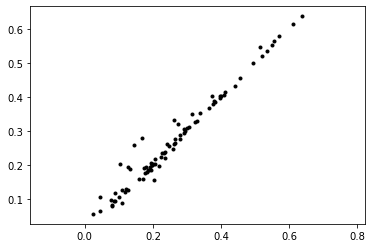

469 samples in Adipose_Visceral_Omentum
17 0.0013849854358722268 0.00584270592146556


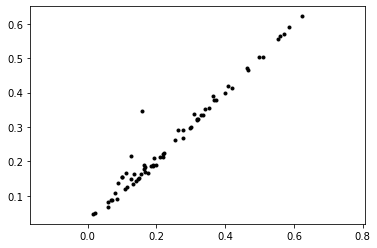

233 samples in Adrenal_Gland
5 0.002184990598659357 0.007845369788197894


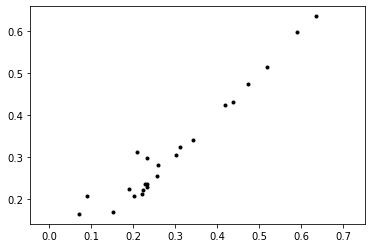

387 samples in Artery_Aorta
7 -0.0028631014879546726 0.00974231326533749


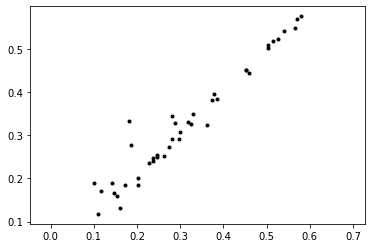

213 samples in Artery_Coronary
6 0.0003233953354985017 0.009819732618676951


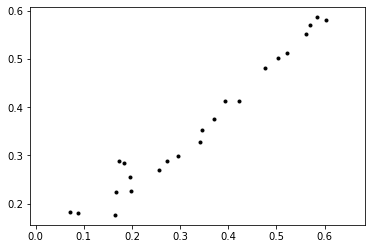

584 samples in Artery_Tibial
18 -0.0004285345834155336 0.00542141541015195


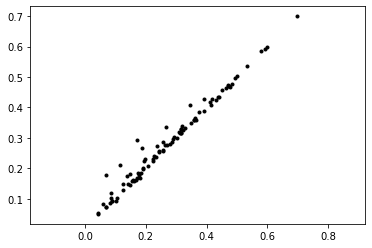

147 samples in Brain_Anterior_cingulate_cortex_BA24
1 0.0003172470695923424 0.015153061991514807


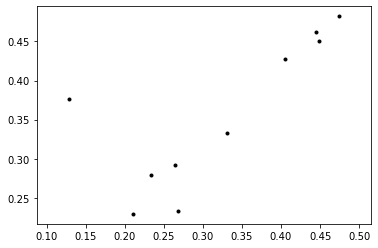

194 samples in Brain_Caudate_basal_ganglia
7 0.0017588196213149 0.011440110815519192


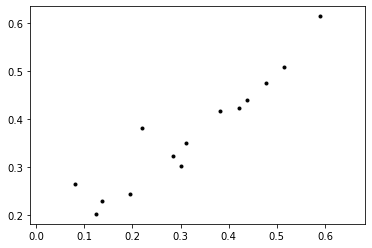

175 samples in Brain_Cerebellar_Hemisphere
7 0.001054927516724787 0.012640991231202428


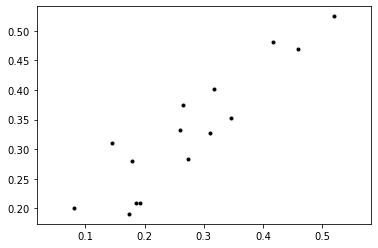

209 samples in Brain_Cerebellum
6 0.0009819718667555526 0.014901671899373917


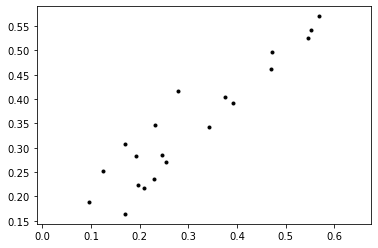

205 samples in Brain_Cortex
8 -8.125523582813753e-05 0.014032702494634897


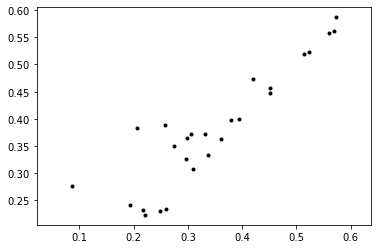

175 samples in Brain_Frontal_Cortex_BA9
5 -0.0019145377109722281 0.013424464207071208


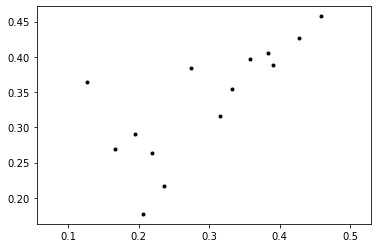

165 samples in Brain_Hippocampus
2 -0.004151970463504774 0.012821418522229708


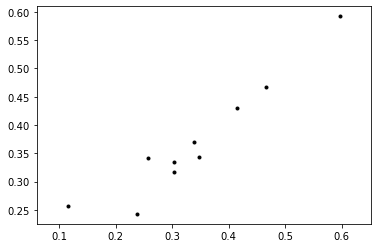

170 samples in Brain_Hypothalamus
6 -0.0034501834091081158 0.009672832786657565


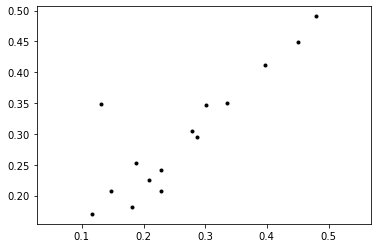

202 samples in Brain_Nucleus_accumbens_basal_ganglia
6 0.0023583476221084023 0.013713297981945701


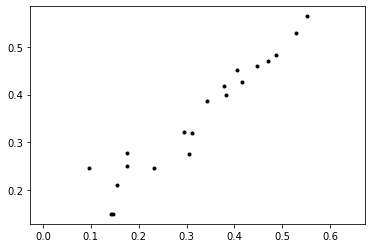

170 samples in Brain_Putamen_basal_ganglia
3 0.0030221880063260433 0.017589658722982637


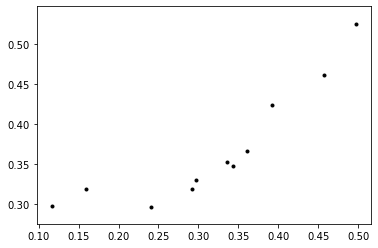

396 samples in Breast_Mammary_Tissue
12 0.002148061412120618 0.00654687244616186


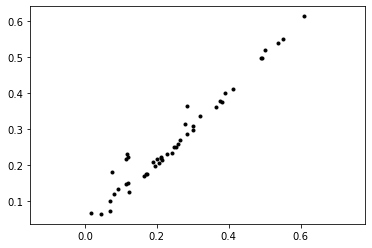

483 samples in Cells_Cultured_fibroblasts
2 -0.002531240714492535 0.016580664268777766


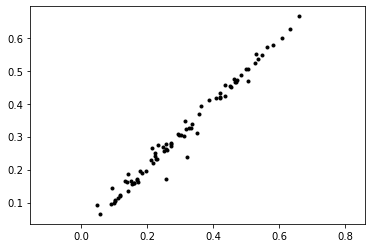

147 samples in Cells_EBV-transformed_lymphocytes
5 0.0043782551778059065 0.0074927323099379635


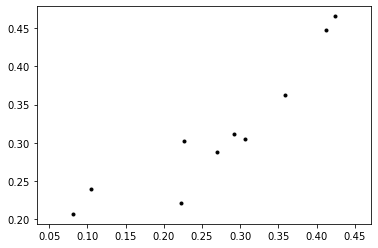

318 samples in Colon_Sigmoid
10 -0.0012411214939278873 0.01128176609956573


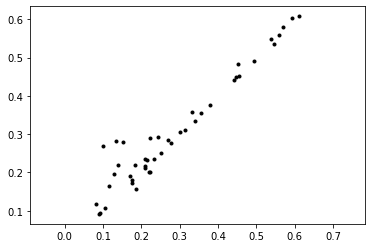

368 samples in Colon_Transverse
13 0.0003820420878396 0.009000980324481687


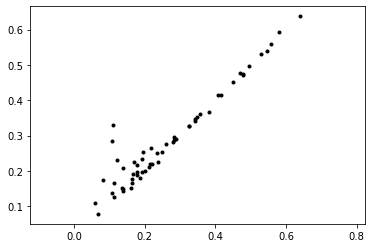

330 samples in Esophagus_Gastroesophageal_Junction
8 -0.00044483472449240933 0.007908961303096335


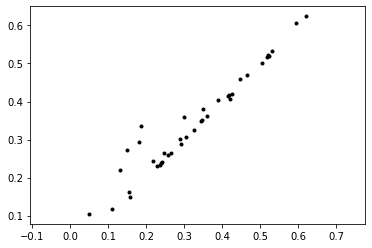

497 samples in Esophagus_Mucosa
16 -0.00039073450144484247 0.007911808005561025


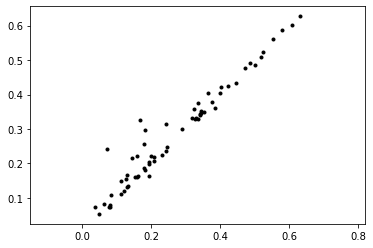

465 samples in Esophagus_Muscularis
11 0.00014413307454147158 0.009156987318818113


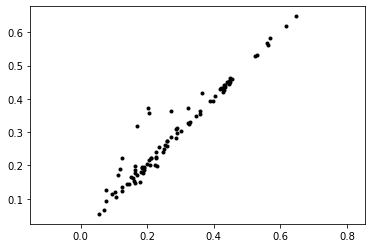

372 samples in Heart_Atrial_Appendage
17 0.0014947300502697253 0.0068387096623433565


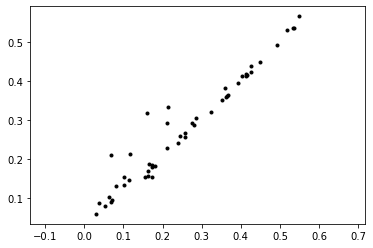

386 samples in Heart_Left_Ventricle
4 -0.000722218021018173 0.008971707797261768


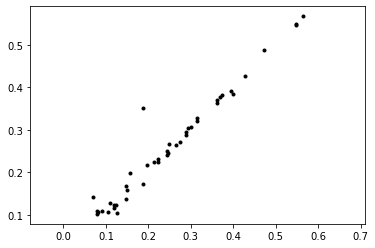

208 samples in Liver
8 0.0019413572287799857 0.007414174082623457


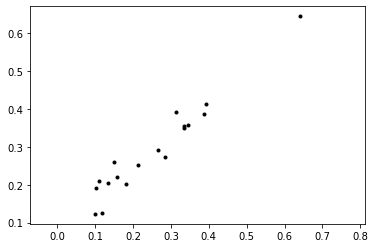

515 samples in Lung
19 0.0010048319521997729 0.007025836006978994


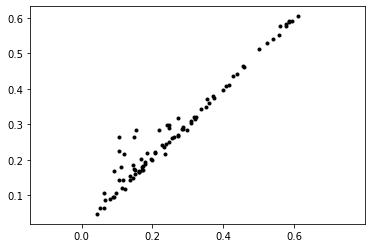

144 samples in Minor_Salivary_Gland
4 0.011386886727943617 0.011444246883439984


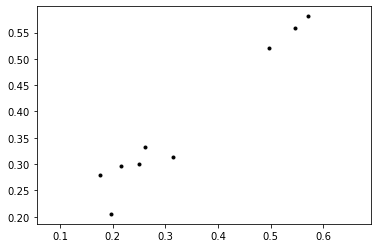

706 samples in Muscle_Skeletal
12 0.0007990188022580424 0.005707197678389732


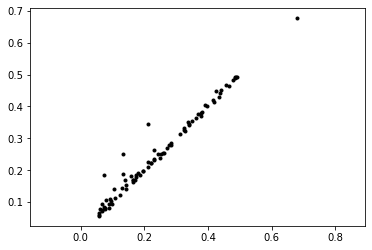

532 samples in Nerve_Tibial
13 -0.000786703640627917 0.008262143729506635


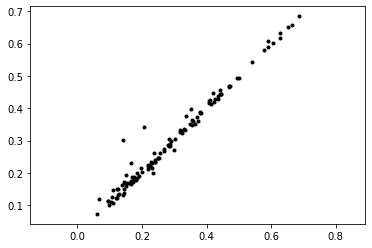

305 samples in Pancreas
7 -0.001813823932729567 0.007347446155116127


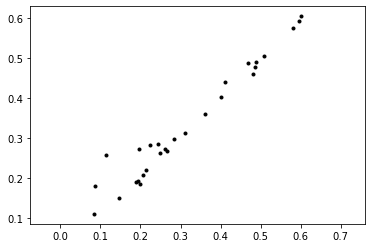

237 samples in Pituitary
6 0.002375235938451848 0.009128938882576617


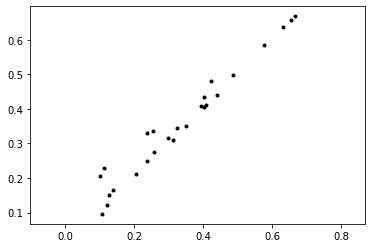

221 samples in Prostate
6 0.0057574123187814135 0.00986036124912229


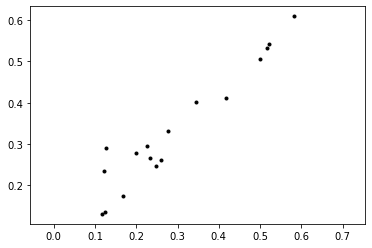

517 samples in Skin_Not_Sun_Exposed_Suprapubic
14 -0.0005297952153812887 0.009704547288067723


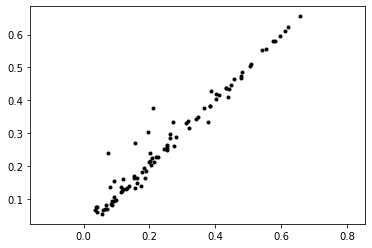

605 samples in Skin_Sun_Exposed_Lower_leg
16 0.0004557605670737233 0.007014606067651527


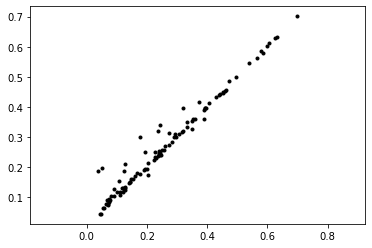

174 samples in Small_Intestine_Terminal_Ileum
7 0.0014096598090995657 0.01325227639320482


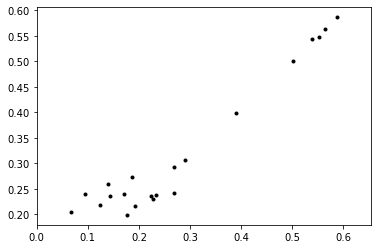

227 samples in Spleen
10 0.0016834837297004968 0.011488513397486253


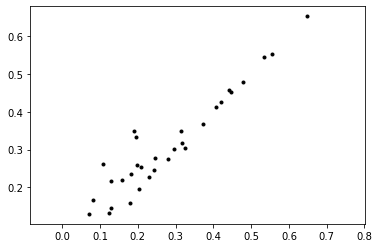

324 samples in Stomach
11 0.001859246766782191 0.010919997586310067


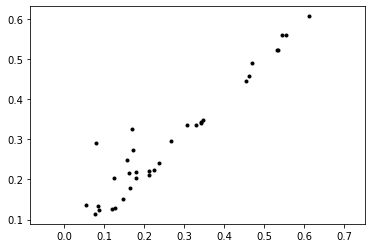

322 samples in Testis
21 -0.001527143390658773 0.007926722264667903


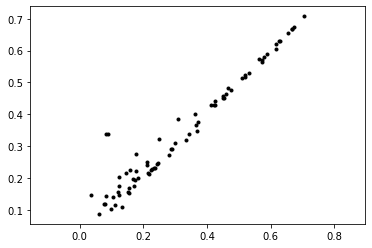

574 samples in Thyroid
11 -0.00024383878879431303 0.008639795024689255


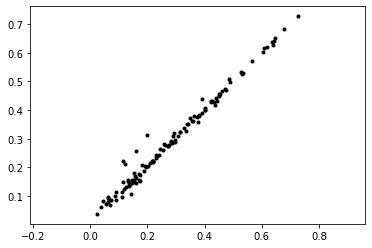

670 samples in Whole_Blood
14 -0.001139345773842996 0.009220061044515459


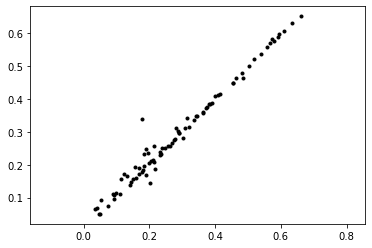

In [95]:
for tissue in np.loadtxt("/scratch2/tsungyul/pm570/input/tissue.txt", dtype=object):
    # load TR, SNP matrices
    tsm = getTissueSampleMask(tissue)
    print(f"{np.sum(tsm)} samples in {tissue}")
    #print("Loading TR matrix")
    ttrMat, ttmMask = trMat[:,tsm], tmMask[:,tsm]
    #print("Loading SNP matrix")
    tsnpMat, tsmMask = tis2snpMat[tissue][0][:,tsm], tis2snpMat[tissue][1][:,tsm]
    
    # Load expression matrix
    #print("Loading residualized TPM matrix")
    tpmMat = loadTisResTpmMat(tissue)
    
    # Indexing genes
    #print("Indexing genes")
    ges, ge2i = indexGeneList(tissue)
    
    # load ePairs
    #print("Indexing ePairs")
    esp, etp, eg2spi, eg2tpi = loadJointeGene(tissue) # eSNP pairs, eTR pairs
    
    # reproduce TR/RNA, SNP/RNA associations
    # joint association
    sigi, r2, ps, bs = runAssociation(tissue, vis=1)
#     reportSignificantPairs(tissue)
    reportPairs(tissue)

581 samples in Adipose_Subcutaneous
12 -0.0011844220890924045 0.009818519871737999


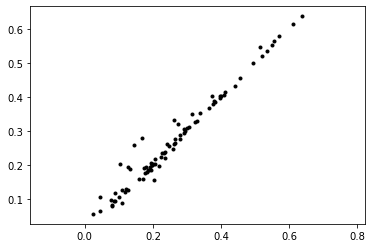

469 samples in Adipose_Visceral_Omentum
17 0.0013249386540718164 0.0058766782551698035


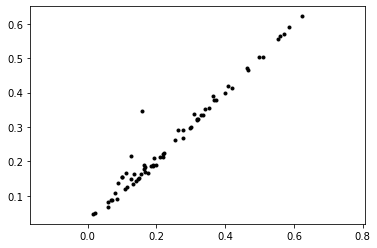

233 samples in Adrenal_Gland
5 0.0019829376634541524 0.007497147383434294


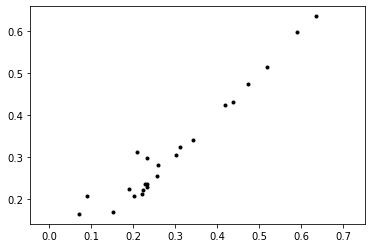

387 samples in Artery_Aorta
7 -0.0025478829368725526 0.010196685149854796


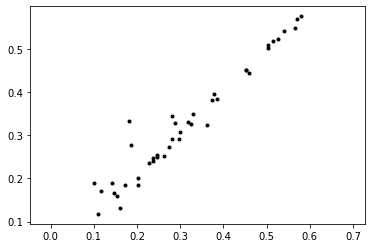

213 samples in Artery_Coronary
6 0.00026636003905821005 0.009988007152013107


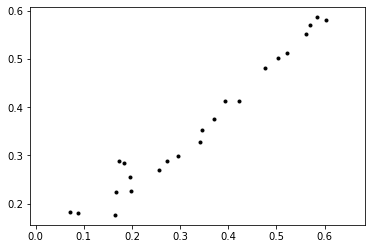

584 samples in Artery_Tibial
18 -0.0003642264655859749 0.005539286783984414


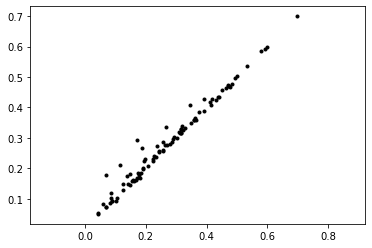

147 samples in Brain_Anterior_cingulate_cortex_BA24
1 0.0006469792631621019 0.01481901085651025


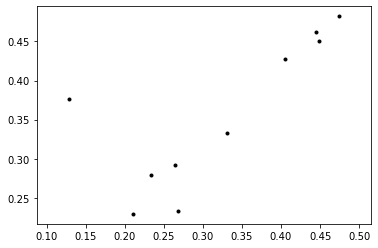

194 samples in Brain_Caudate_basal_ganglia
6 0.0017403276614598056 0.011869799860724494


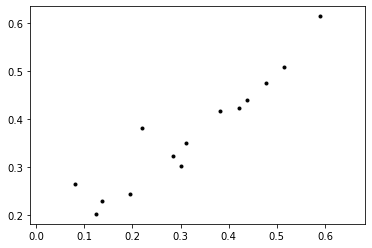

175 samples in Brain_Cerebellar_Hemisphere
7 0.0005232827344515927 0.012141863990661922


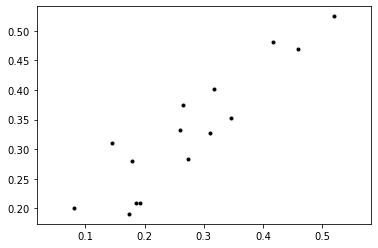

209 samples in Brain_Cerebellum
6 0.0008982318069378108 0.014357060730686993


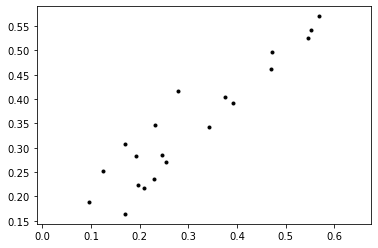

205 samples in Brain_Cortex
8 0.0004145468613070477 0.014290111897006116


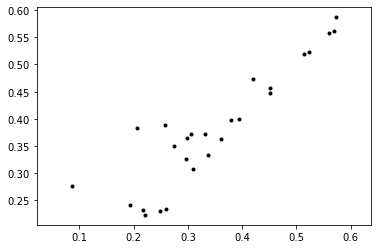

175 samples in Brain_Frontal_Cortex_BA9
6 -0.0026777832617992476 0.012307577117010682


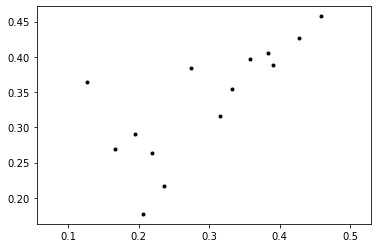

165 samples in Brain_Hippocampus
2 -0.003171669496281203 0.013191207654273226


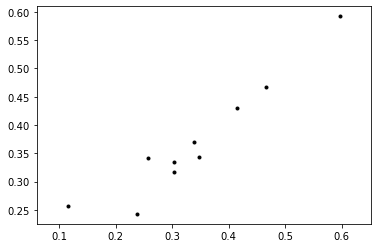

170 samples in Brain_Hypothalamus
6 -0.004530478573755169 0.009743797598209245


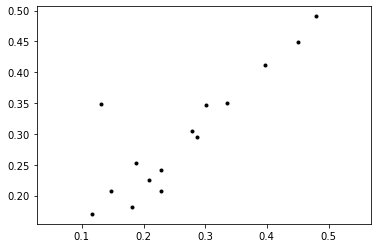

202 samples in Brain_Nucleus_accumbens_basal_ganglia
6 0.0014022055411361362 0.012783900455344074


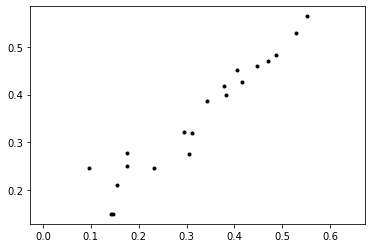

170 samples in Brain_Putamen_basal_ganglia
2 0.004456665076379538 0.019259499177004504


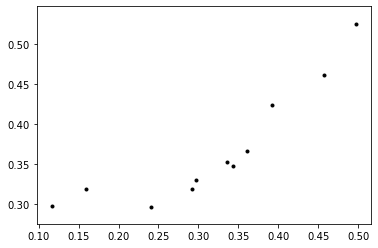

396 samples in Breast_Mammary_Tissue
12 0.0023174058260475435 0.006271913520300048


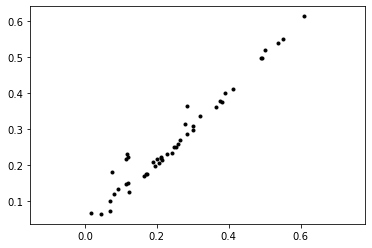

483 samples in Cells_Cultured_fibroblasts
2 -0.002463718112014139 0.01664037745502215


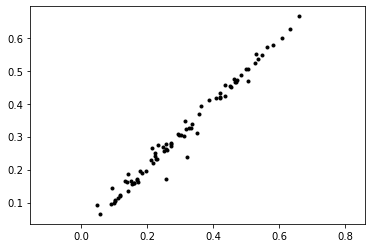

147 samples in Cells_EBV-transformed_lymphocytes
4 0.00560722630467812 0.009609178926753007


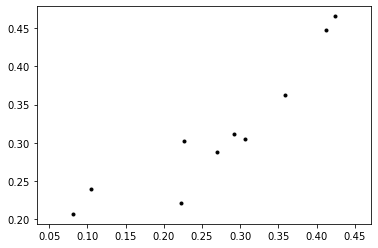

318 samples in Colon_Sigmoid
10 -0.0011568440218033865 0.011443841170919091


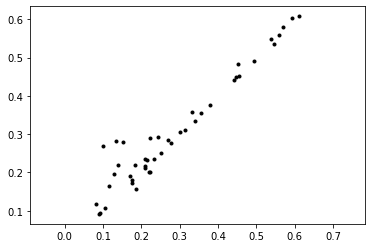

368 samples in Colon_Transverse
13 0.00046414739560937565 0.008803890773074937


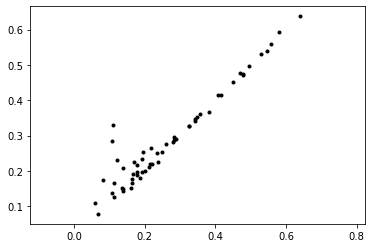

330 samples in Esophagus_Gastroesophageal_Junction
8 -0.0001802825243074672 0.00832929284473525


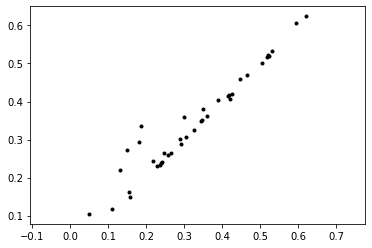

497 samples in Esophagus_Mucosa
16 -0.00045142838797633913 0.007875626878862082


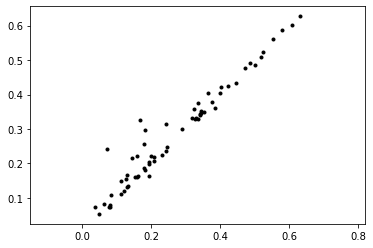

465 samples in Esophagus_Muscularis
11 0.0002751767604915671 0.009079326495813524


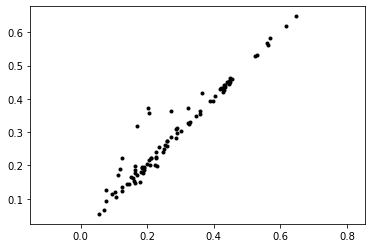

372 samples in Heart_Atrial_Appendage
17 0.001672456876831208 0.006712447414191376


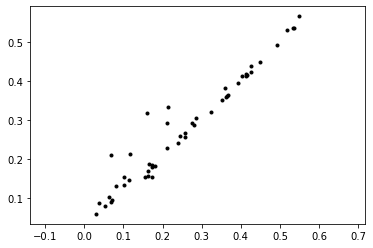

386 samples in Heart_Left_Ventricle
4 -0.0008988005752170077 0.009241844653758614


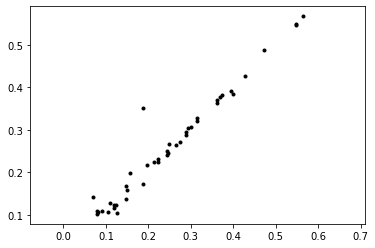

208 samples in Liver
7 0.0024520686989358245 0.008219938585825768


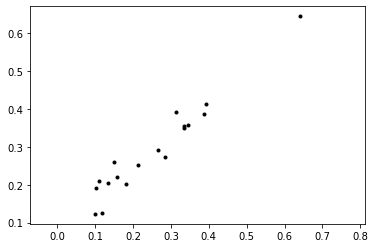

515 samples in Lung
19 0.0010021675713272602 0.007213873672542251


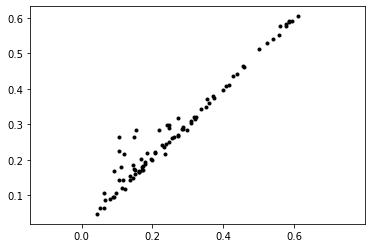

144 samples in Minor_Salivary_Gland
4 0.009085876141688631 0.00946559033651111


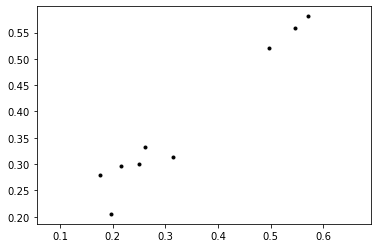

706 samples in Muscle_Skeletal
12 0.0008835114693408495 0.005740635318758281


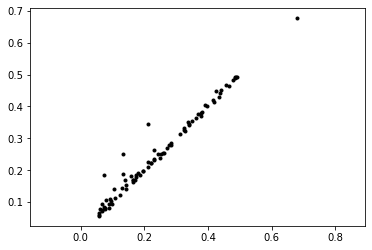

532 samples in Nerve_Tibial
13 -0.0007739485490002317 0.008358467245180645


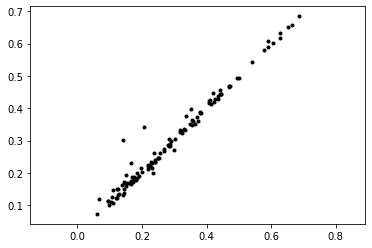

305 samples in Pancreas
7 -0.0015174040303275655 0.007420550951373969


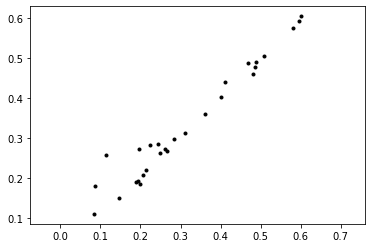

237 samples in Pituitary
6 0.002318977563408034 0.00893298788504301


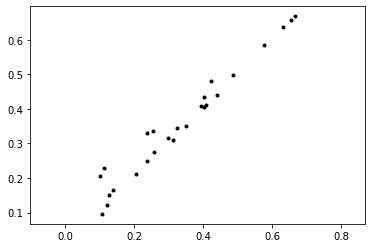

221 samples in Prostate
6 0.006228283150761533 0.009795415770749268


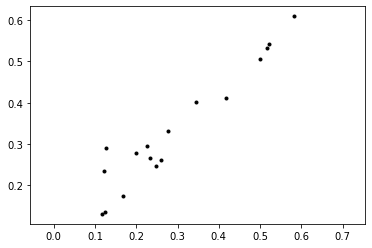

517 samples in Skin_Not_Sun_Exposed_Suprapubic
14 -0.0004087744888136006 0.009686037776511263


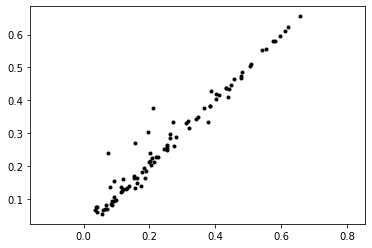

605 samples in Skin_Sun_Exposed_Lower_leg
16 0.0005875654700428374 0.007067927648151147


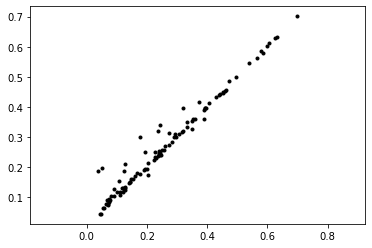

174 samples in Small_Intestine_Terminal_Ileum
7 0.0014721560576736602 0.013315963008487124


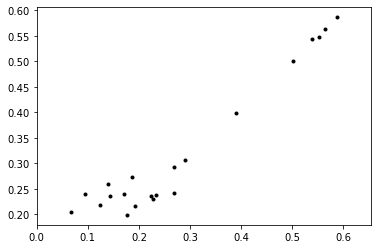

227 samples in Spleen
10 0.002021433148488555 0.011894586700224814


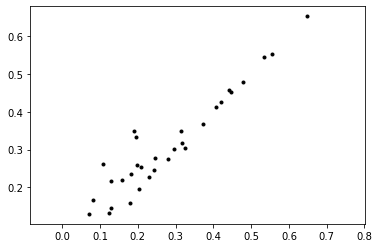

324 samples in Stomach
11 0.0025829522214555465 0.01111703658547317


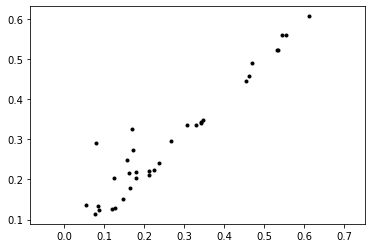

322 samples in Testis
21 -0.0015298972716270042 0.008058243310874059


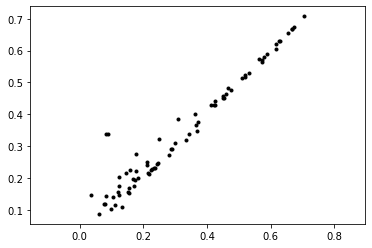

574 samples in Thyroid
11 -0.00030263712851936135 0.008508828317747933


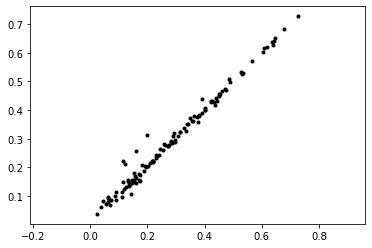

670 samples in Whole_Blood
14 -0.0011649514246047518 0.009247947313374538


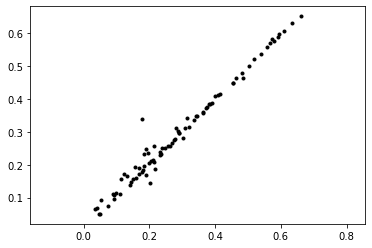

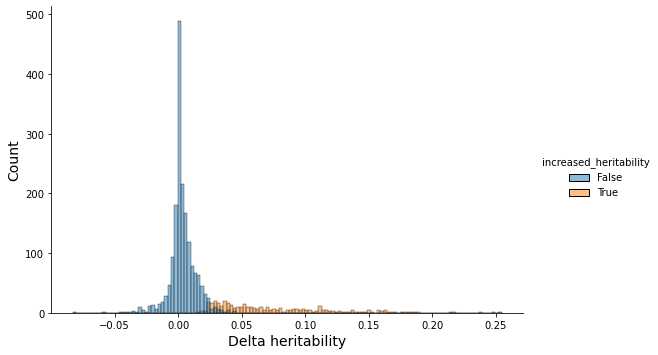

In [82]:
def test():
    allp = np.loadtxt("/scratch2/tsungyul/pm570/output/meta/meta.all.pairs.tsv", dtype=object)
    ids = ["_".join(v) for v in allp[:,[0,3]]]
#     id2i = {}
#     for i, v in enumerate(ids):
#         ids2i[v] = i
    sigp = np.loadtxt("/scratch2/tsungyul/pm570/output/meta/meta.significant.pairs.tsv", dtype=object)
    sids = ["_".join(v) for v in sigp[:,[0,3]]]
    m = np.isin(ids,sids)
    df = pd.DataFrame()
    df["delta_heritability"] = allp[:,1].astype(float)
    df["increased_heritability"] = m
    ax = sns.displot(df, x="delta_heritability", hue="increased_heritability", height=5, aspect=1.5)
    ax.set_xlabels("Delta heritability", fontsize=14)
    ax.set_ylabels(fontsize=14)
    plt.show(); plt.close()
    
#     tbl = np.loadtxt("/scratch2/tsungyul/pm570/output/meta/meta.significant.pairs.tsv", dtype=object)
#     df = pd.DataFrame()
#     df["delta_heritability"] = tbl[:,1].astype(float)
#     sns.displot(df, x="delta_heritability")
#     plt.show(); plt.close()

test()

469 samples in Adipose_Visceral_Omentum
ENSG00000168528.11
ENSG00000237975.6
ENSG00000197915.5
ENSG00000143631.10
ENSG00000172554.11
ENSG00000270571.2
ENSG00000115364.13
ENSG00000146556.14
ENSG00000236397.3
ENSG00000279267.1
ENSG00000196151.10
ENSG00000220804.8
ENSG00000224769.1
ENSG00000271662.1
ENSG00000229178.1
ENSG00000207650.1
ENSG00000283426.1
ENSG00000168993.14
ENSG00000124406.16
ENSG00000138744.14
ENSG00000138750.14
ENSG00000249378.5
ENSG00000221990.4
ENSG00000206077.10
ENSG00000249908.2
ENSG00000188818.12
ENSG00000113303.11
ENSG00000168903.8
ENSG00000233967.6
ENSG00000164465.18
ENSG00000026297.15
ENSG00000184465.15
ENSG00000130024.14
ENSG00000273100.1
ENSG00000156482.10
ENSG00000164924.17
ENSG00000254812.1
ENSG00000275160.1
ENSG00000264230.7
ENSG00000119242.8
ENSG00000184967.6
ENSG00000032742.17
ENSG00000238286.1
ENSG00000258701.1
ENSG00000211974.3
ENSG00000259430.1
ENSG00000270127.2
ENSG00000259205.2
ENSG00000242612.6
ENSG00000274627.1
ENSG00000167914.11
ENSG00000262500.1
ENS

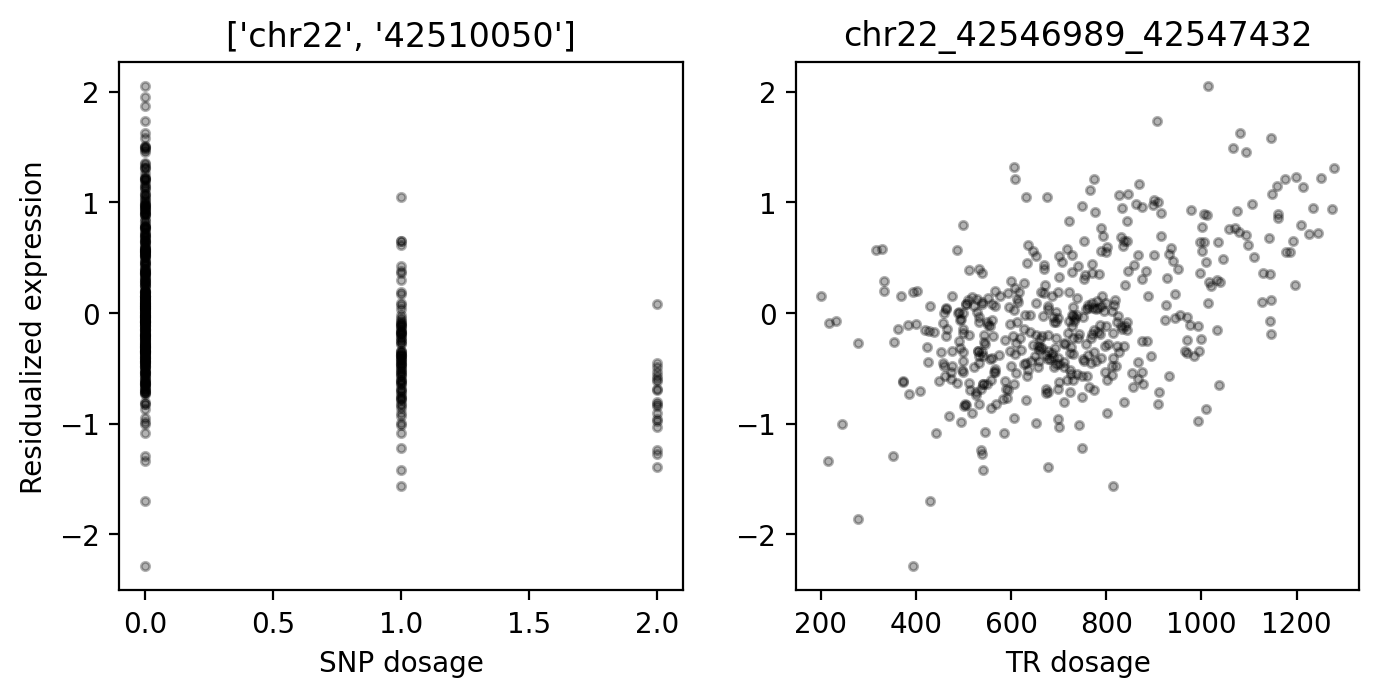

17 0.0015239267972825096 0.005828748263673539


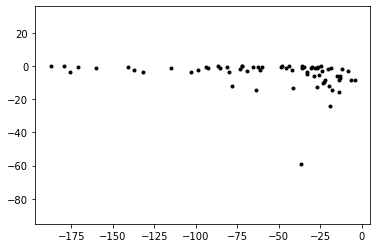

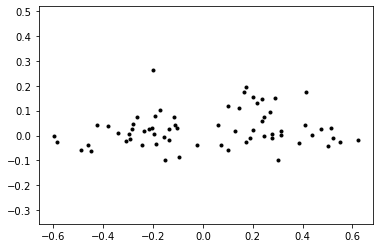

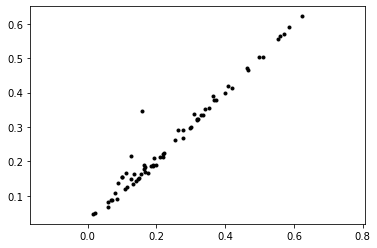

In [93]:
tissue = "Adipose_Visceral_Omentum"
# load TR, SNP matrices
tsm = getTissueSampleMask(tissue)
print(f"{np.sum(tsm)} samples in {tissue}")
#print("Loading TR matrix")
ttrMat, ttmMask = trMat[:,tsm], tmMask[:,tsm]
#print("Loading SNP matrix")
tsnpMat, tsmMask = tis2snpMat[tissue][0][:,tsm], tis2snpMat[tissue][1][:,tsm]

# Load expression matrix
#print("Loading residualized TPM matrix")
tpmMat = loadTisResTpmMat(tissue)

# Indexing genes
#print("Indexing genes")
ges, ge2i = indexGeneList(tissue)

# load ePairs
#print("Indexing ePairs")
esp, etp, eg2spi, eg2tpi = loadJointeGene(tissue) # eSNP pairs, eTR pairs

# reproduce TR/RNA, SNP/RNA associations
# joint association
sigi, r2, ps, bs = runAssociation(tissue, vis=2)

670 samples in Whole_Blood
Loading TR matrix
Loading SNP matrix
Loading residualized TPM matrix
Indexing genes
Indexing ePairs
loading raw data
ENSG00000168528.11


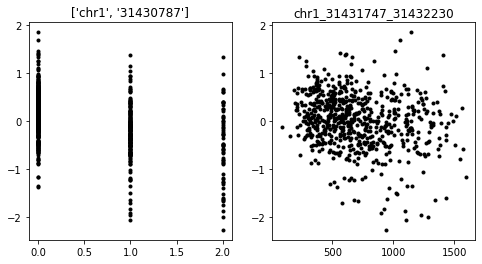

ENSG00000146556.14


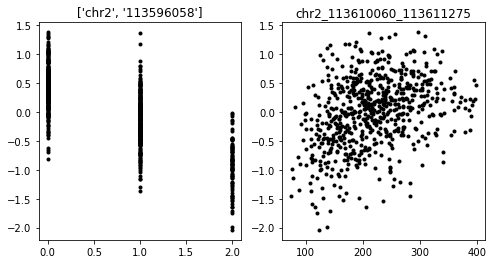

ENSG00000236397.3


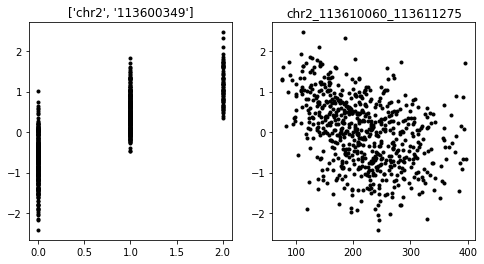

ENSG00000279267.1


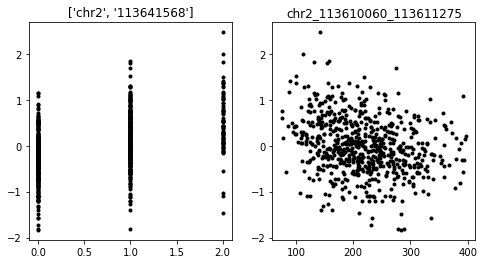

ENSG00000240356.6


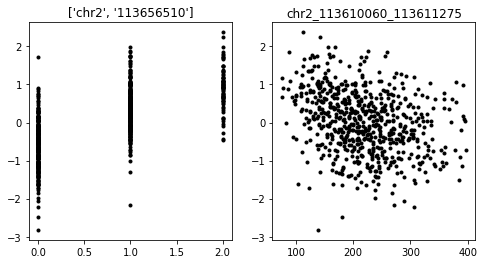

ENSG00000125629.14


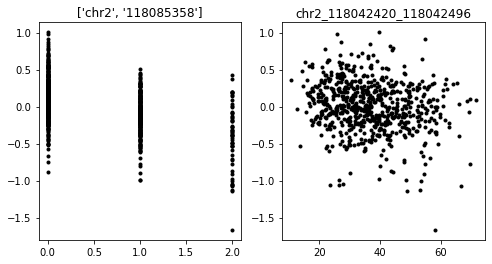

ENSG00000173559.12


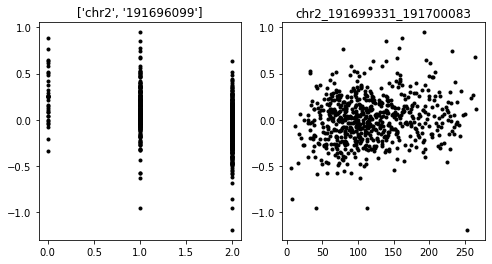

ENSG00000265992.1


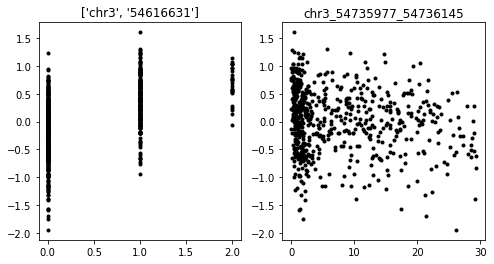

ENSG00000144815.15


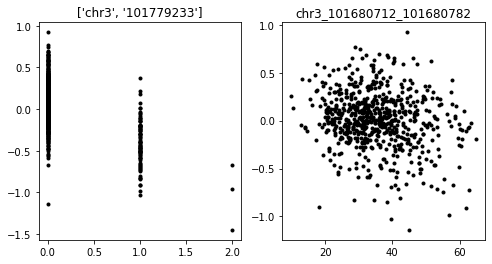

Whole_Blood lead SNP chr3_195960880_G_A_b38 for ENSG00000224769.1 not within 100kb range
Whole_Blood lead SNP chr3_195938879_A_C_b38 for ENSG00000215837.7 not within 100kb range
Whole_Blood lead SNP chr3_196016034_C_T_b38 for ENSG00000283426.1 not within 100kb range
ENSG00000168824.14


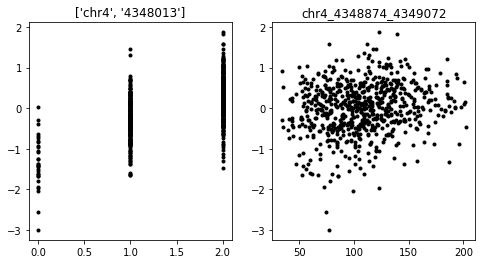

ENSG00000196526.10


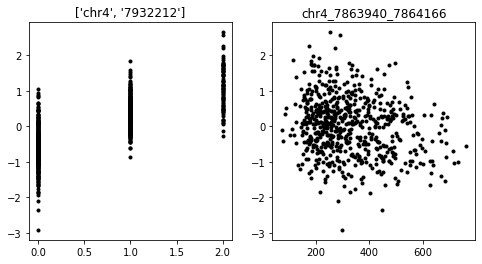

ENSG00000259959.1


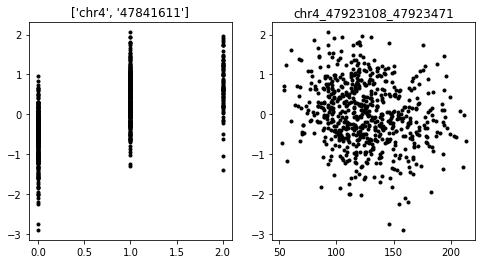

ENSG00000170448.11


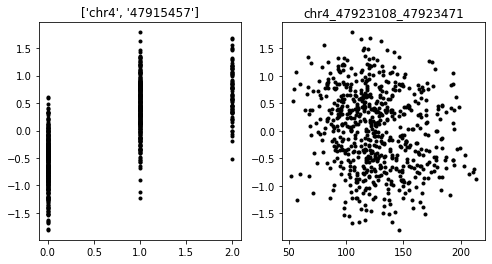

ENSG00000197888.2


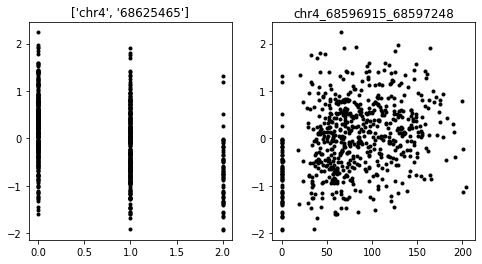

ENSG00000138744.14


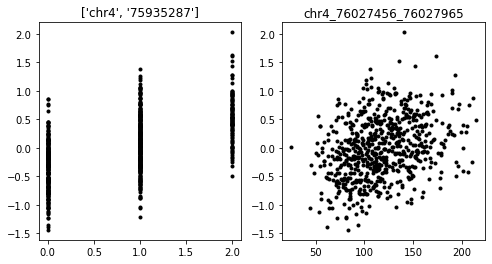

ENSG00000164366.3


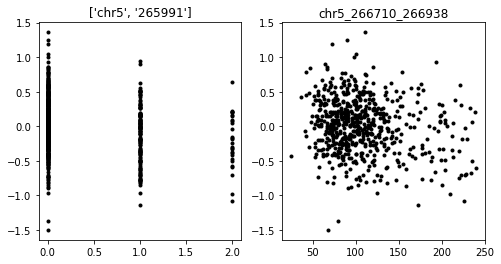

ENSG00000073578.16


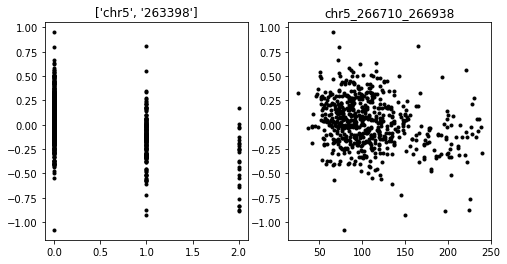

ENSG00000180104.15


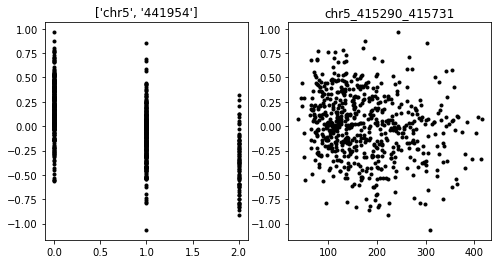

ENSG00000206077.10


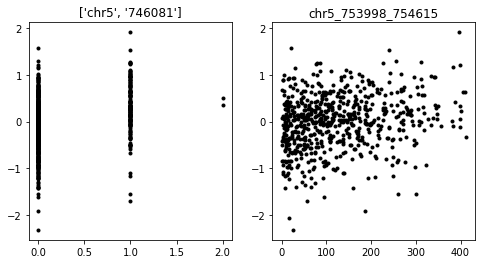

ENSG00000278970.1


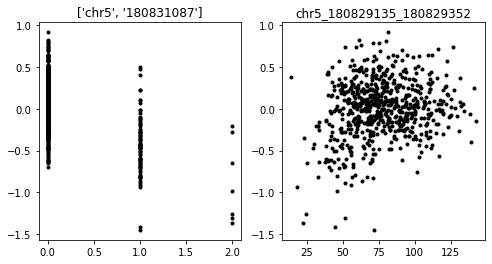

ENSG00000113303.11


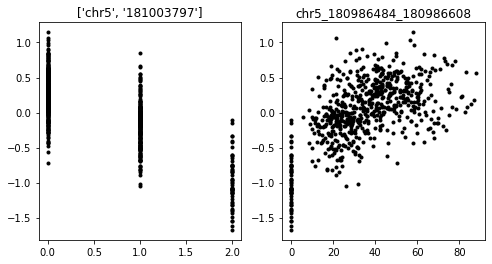

ENSG00000168903.8


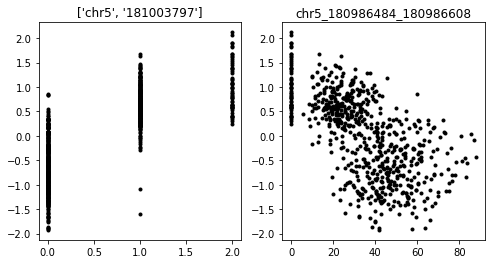

ENSG00000165810.16


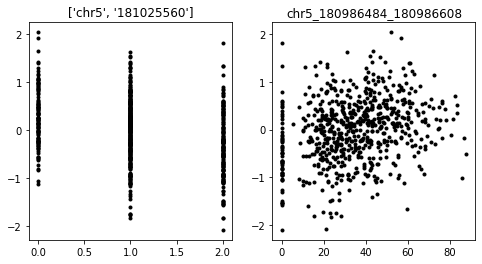

ENSG00000164465.18


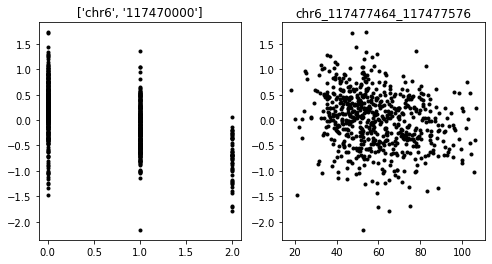

ENSG00000071242.11


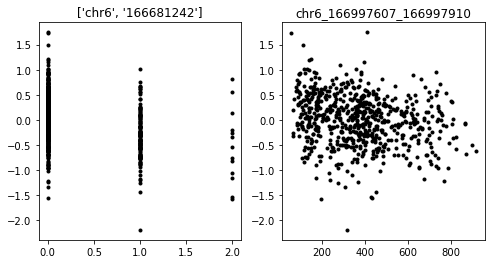

ENSG00000026297.15


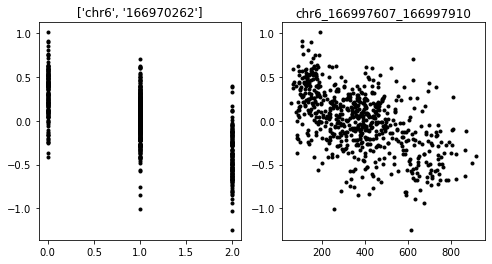

ENSG00000227598.1


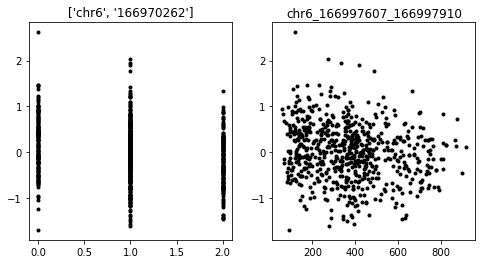

ENSG00000185127.6


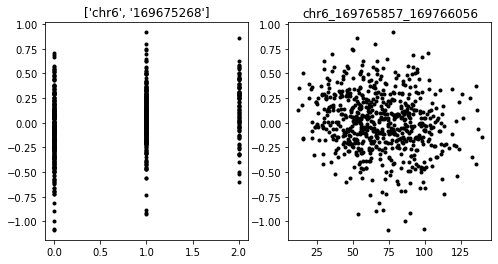

ENSG00000130024.14


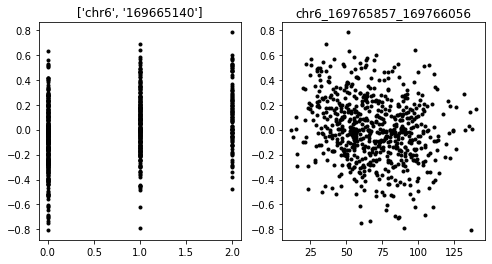

ENSG00000146700.8


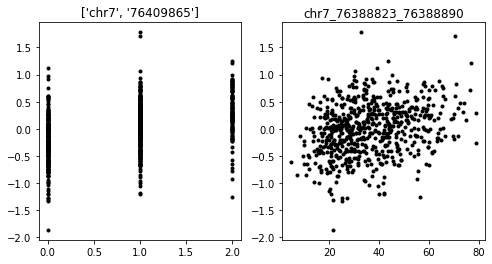

Whole_Blood lead SNP chr7_76621489_C_T_b38 for ENSG00000188372.14 not within 100kb range
ENSG00000091073.19


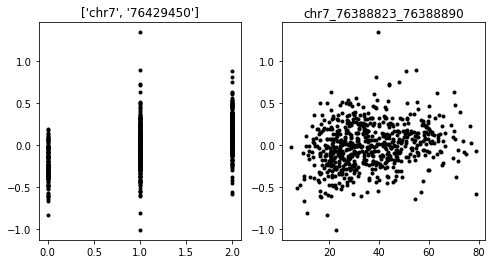

ENSG00000117868.15


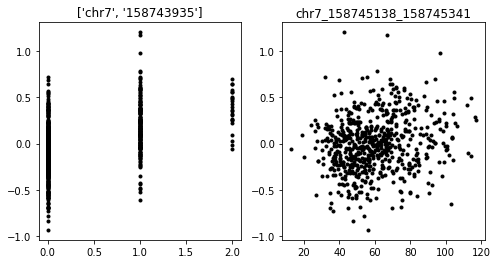

ENSG00000178209.14


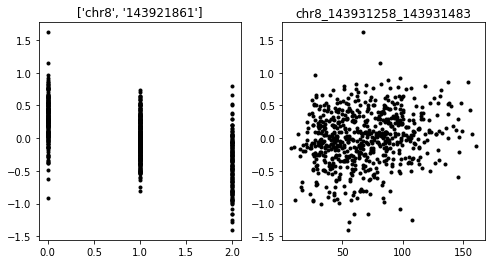

ENSG00000233013.9


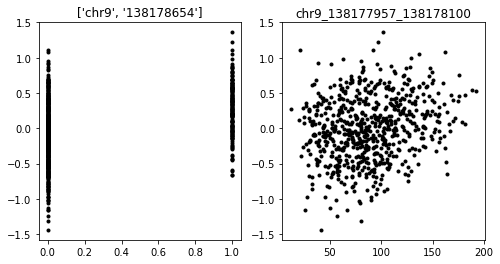

ENSG00000197142.10


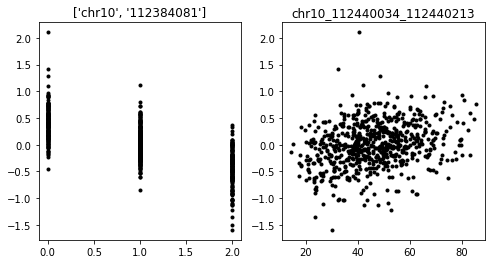

ENSG00000232934.7


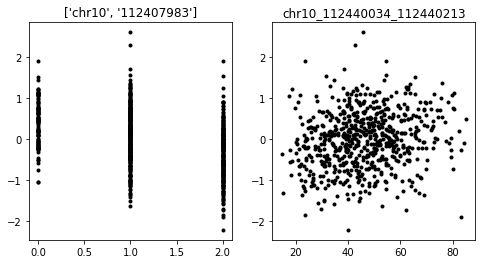

ENSG00000270030.1


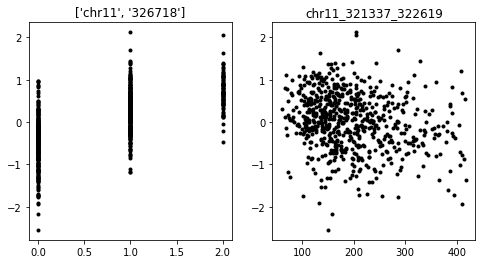

ENSG00000197345.12


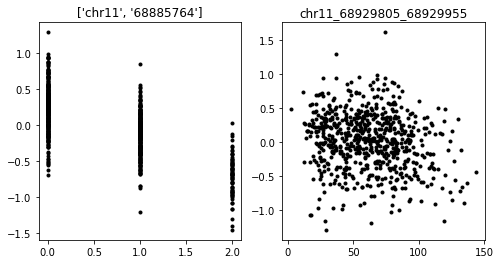

ENSG00000132740.8


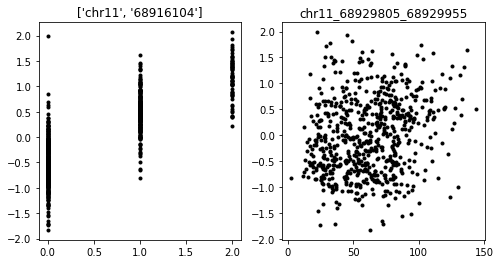

ENSG00000256020.1


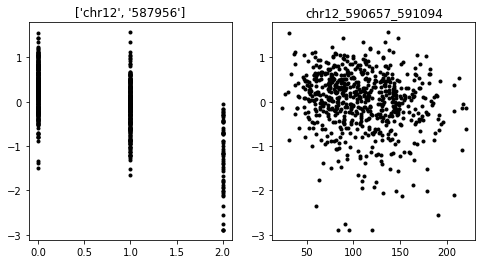

ENSG00000133687.15


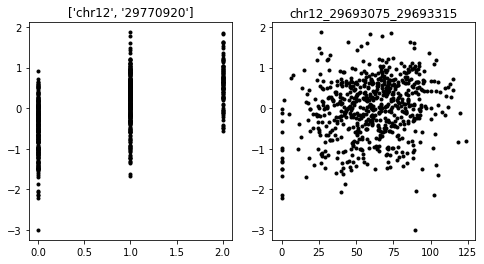

ENSG00000184967.6


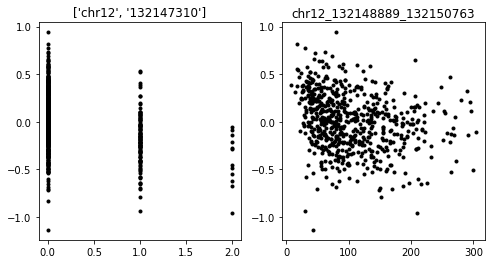

ENSG00000032742.17


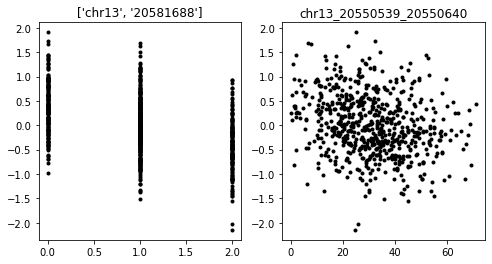

ENSG00000184986.10


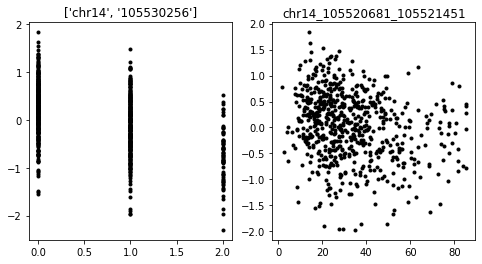

ENSG00000223648.4


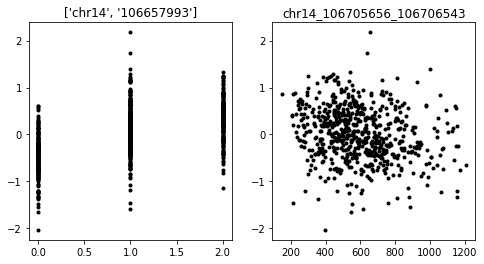

ENSG00000211972.2


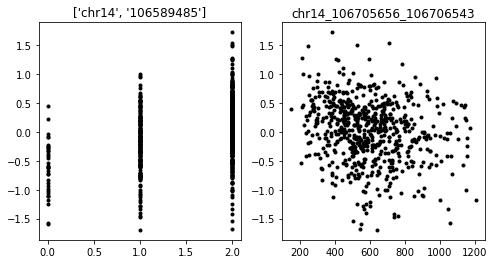

ENSG00000211973.2


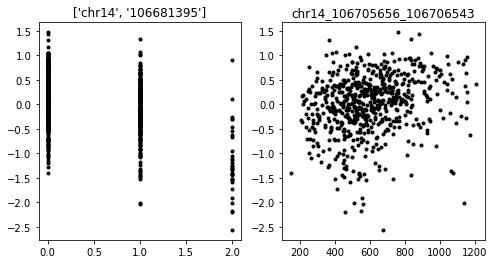

ENSG00000211974.3


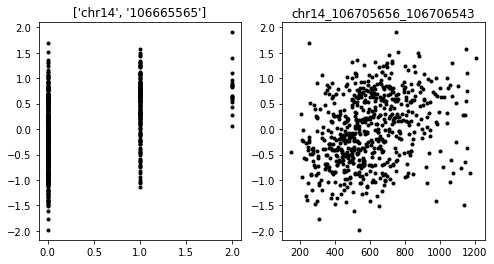

ENSG00000281990.1


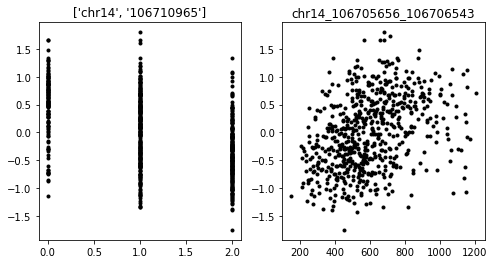

ENSG00000280411.1


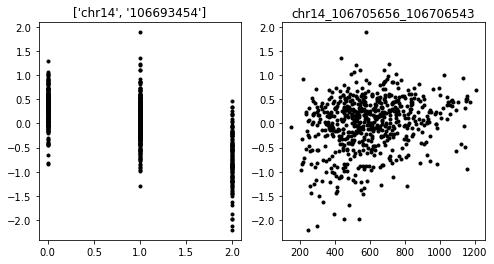

ENSG00000258732.1


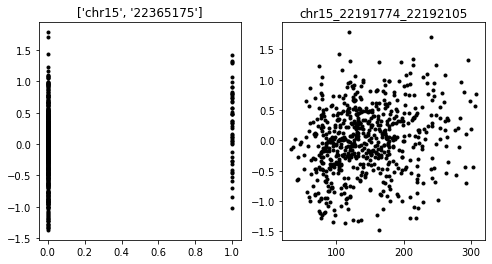

Whole_Blood lead SNP chr15_34378690_G_A_b38 for ENSG00000215252.11 not within 100kb range
ENSG00000270127.2


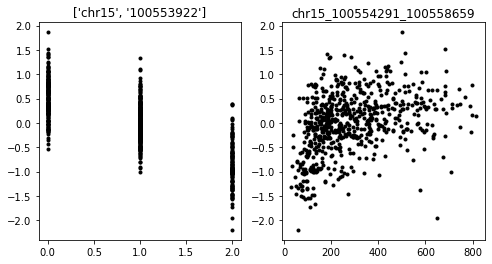

ENSG00000259205.2


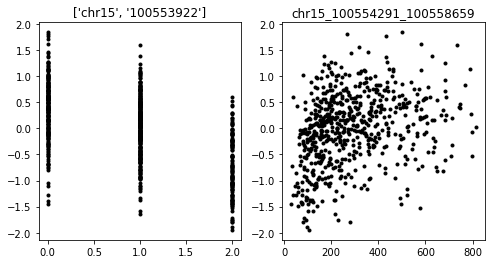

ENSG00000178952.10


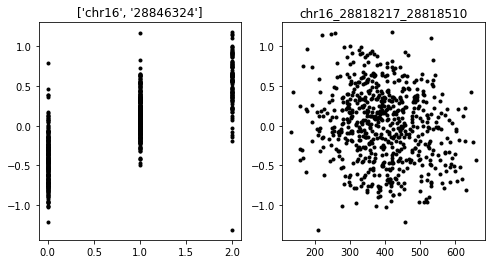

ENSG00000182885.16


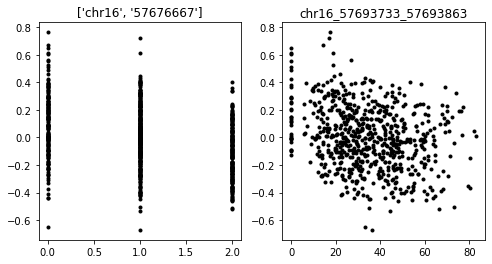

ENSG00000159625.14


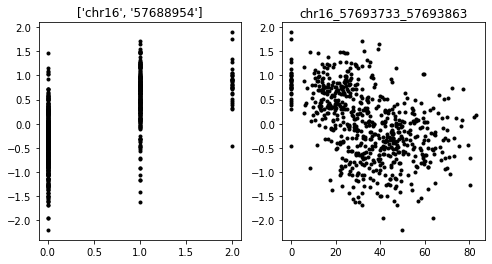

ENSG00000205309.13


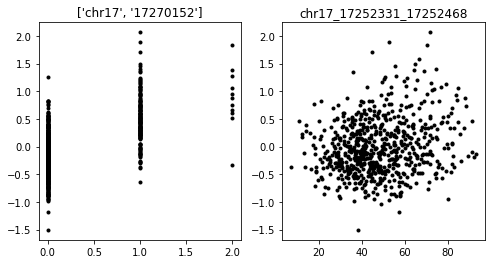

ENSG00000073605.18


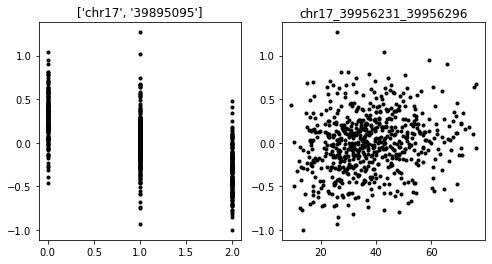

ENSG00000172057.9


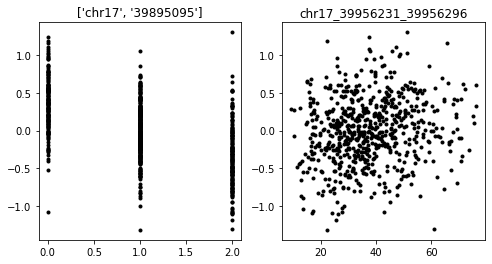

Whole_Blood lead SNP chr17_45581150_C_T_b38 for ENSG00000214401.4 not within 100kb range
ENSG00000120071.13


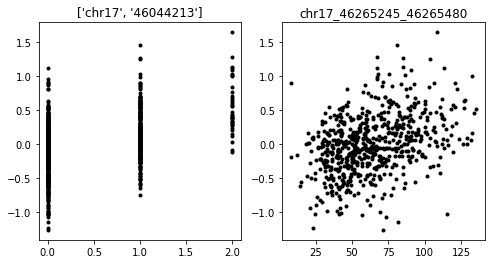

ENSG00000262500.1


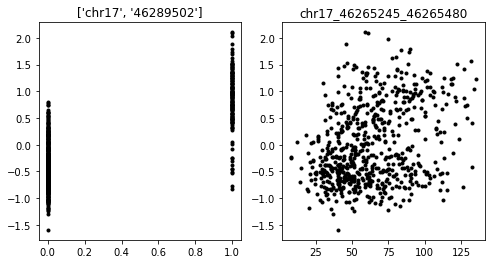

Whole_Blood lead SNP chr17_45587535_T_A_b38 for ENSG00000262539.1 not within 100kb range
ENSG00000228696.8


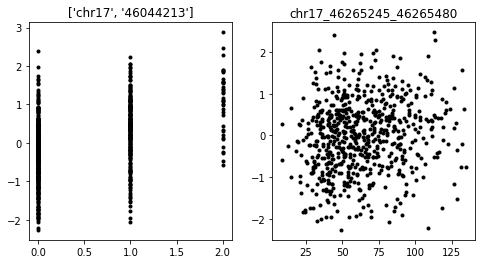

ENSG00000263627.1


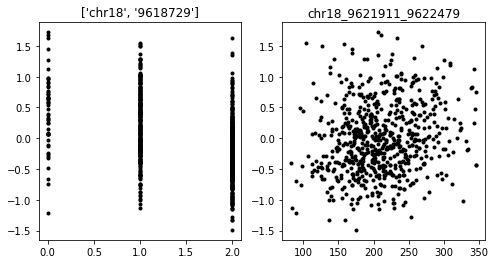

ENSG00000167644.11


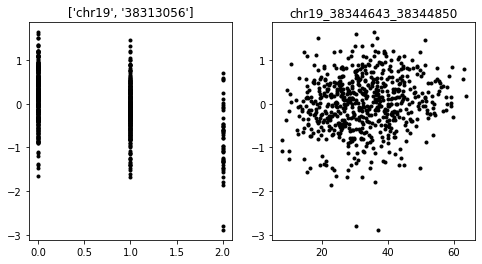

ENSG00000039650.11


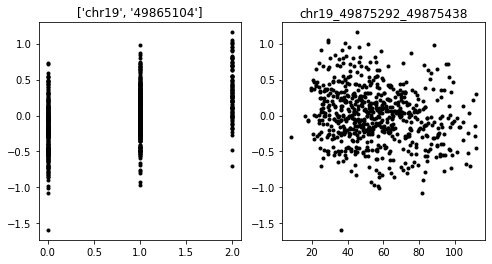

ENSG00000235081.1


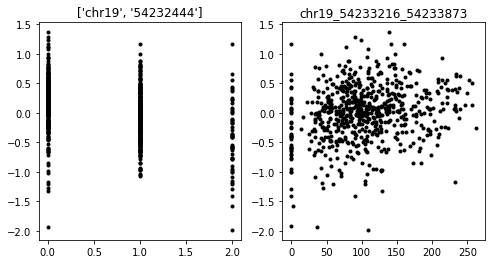

ENSG00000244482.10


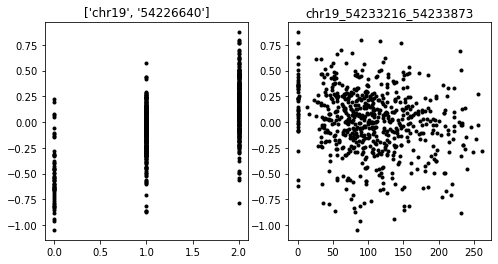

ENSG00000131042.14


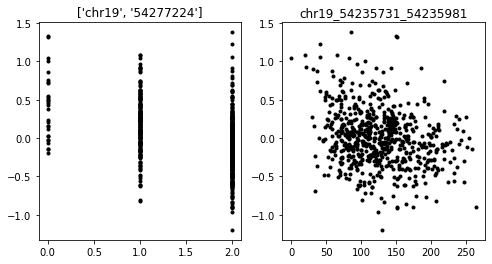

ENSG00000239961.2


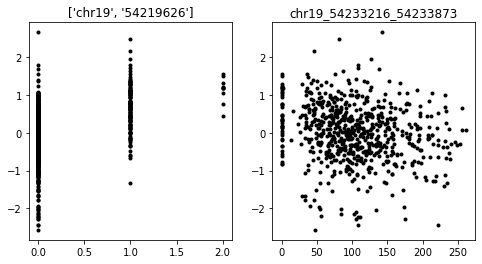

ENSG00000101457.12


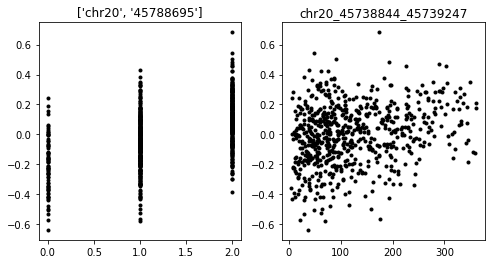

ENSG00000196421.8


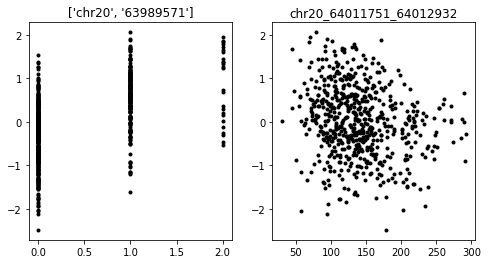

ENSG00000241945.7


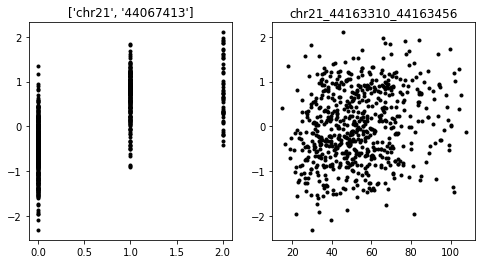

ENSG00000160221.16


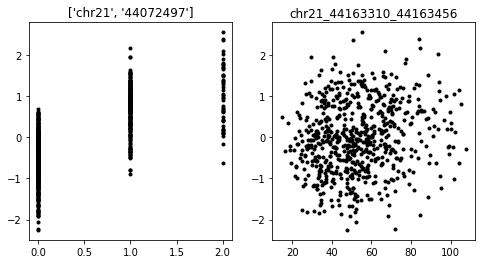

ENSG00000182362.13


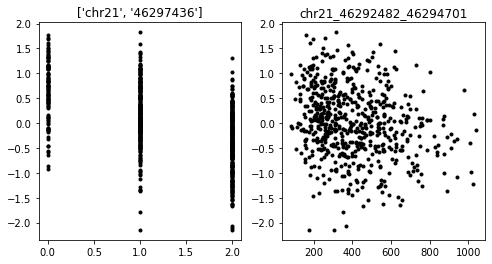

Whole_Blood lead SNP chr22_21335586_C_T_b38 for ENSG00000206140.10 not within 100kb range
ENSG00000279278.1


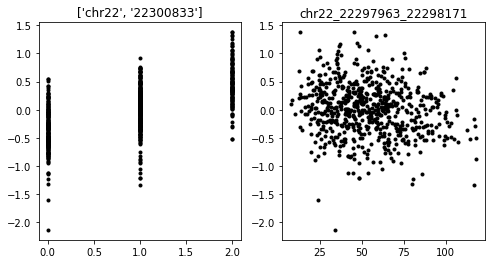

ENSG00000272779.1


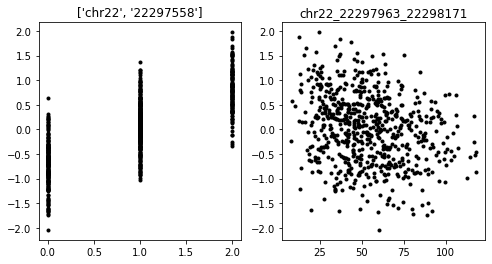

ENSG00000211666.2


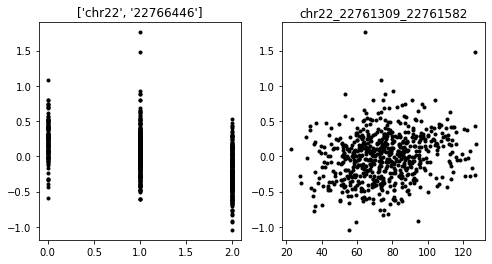

ENSG00000211667.2


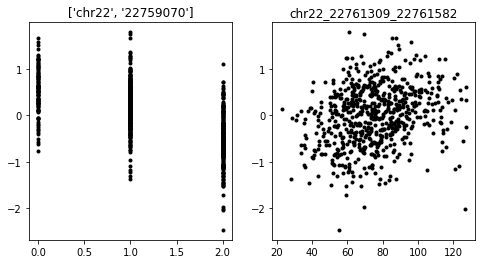

ENSG00000100068.11


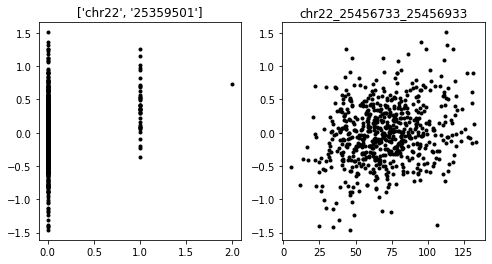

ENSG00000100058.12


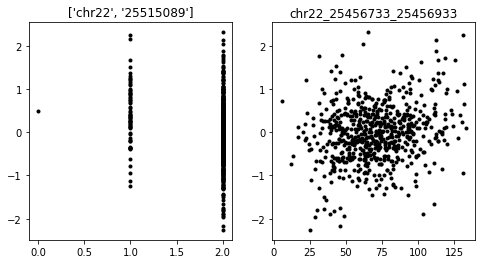

ENSG00000272977.1


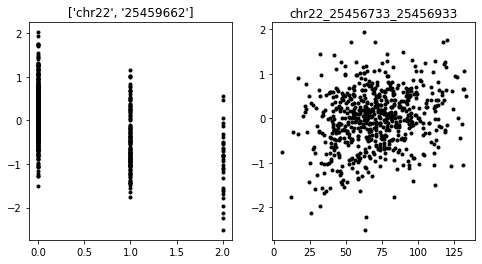

ENSG00000128383.12


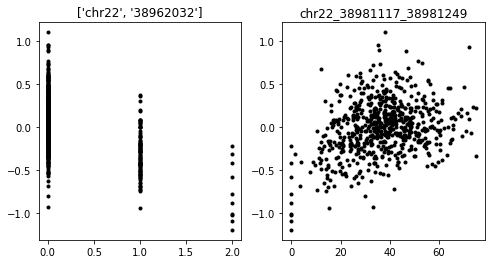

ENSG00000189306.10


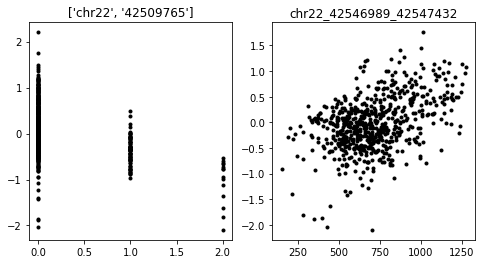

ENSG00000018610.13


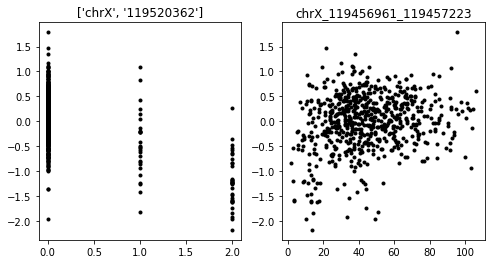

706 samples in Muscle_Skeletal
Loading TR matrix
Loading SNP matrix
Loading residualized TPM matrix
Indexing genes
Indexing ePairs
loading raw data
ENSG00000168528.11


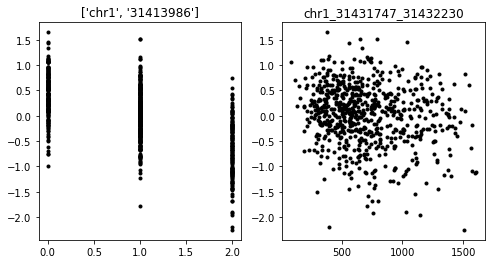

ENSG00000237975.6


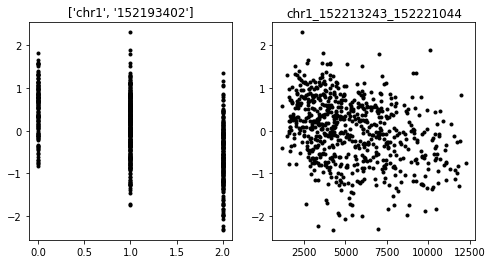

ENSG00000118197.13


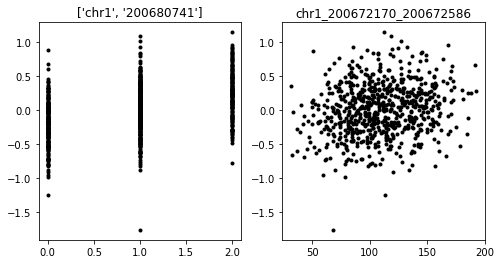

ENSG00000143776.18


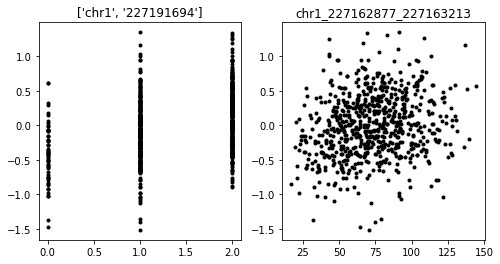

ENSG00000054277.13


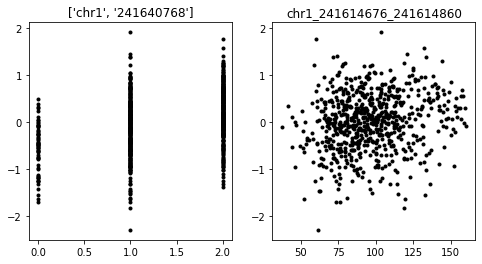

ENSG00000119185.12


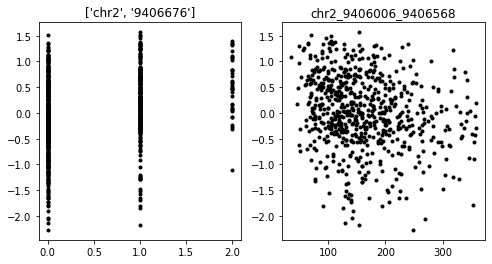

ENSG00000115364.13


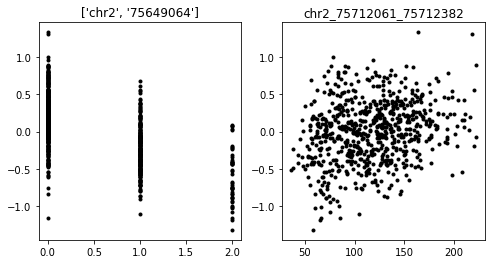

ENSG00000270696.1


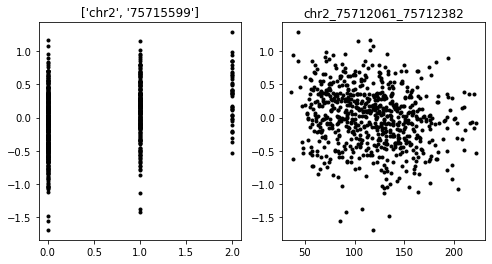

ENSG00000271452.1


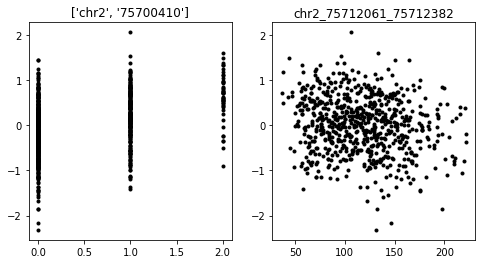

ENSG00000146556.14


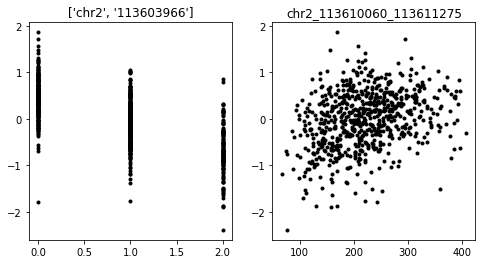

ENSG00000236397.3


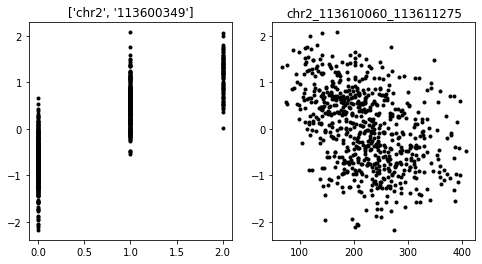

ENSG00000279267.1


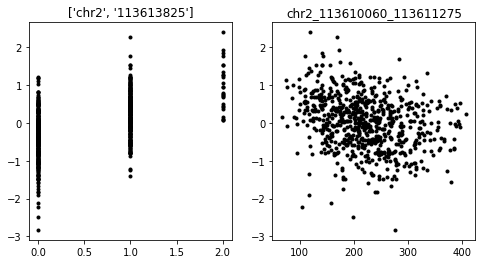

ENSG00000240356.6


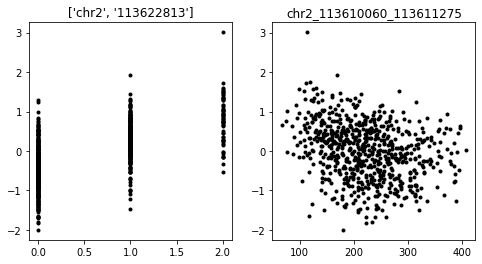

ENSG00000196151.10


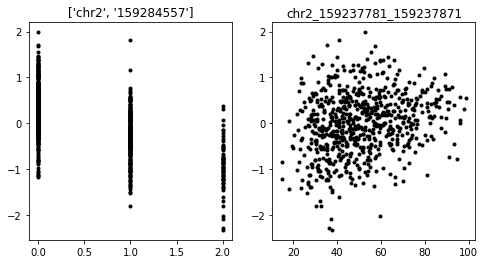

ENSG00000077380.15


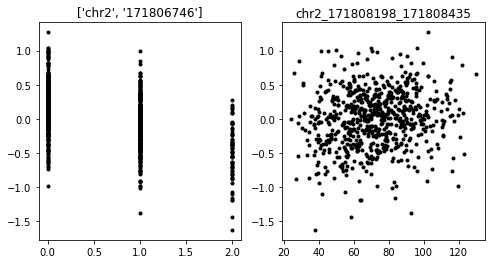

ENSG00000172878.13


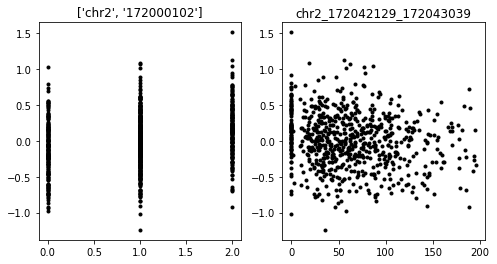

ENSG00000261186.2


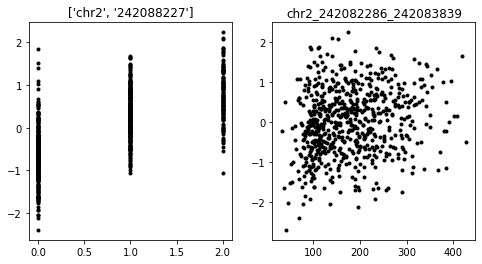

Muscle_Skeletal lead SNP chr2_241828903_T_TATAATA_b38 for ENSG00000220804.8 not within 100kb range
ENSG00000271964.1


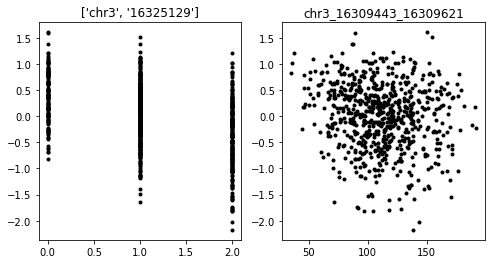

ENSG00000239959.1


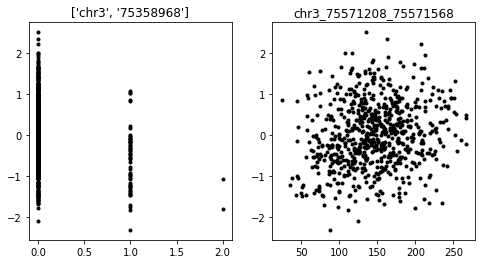

ENSG00000224769.1


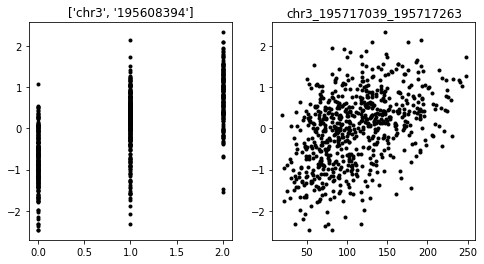

Muscle_Skeletal lead SNP chr3_195940467_G_A_b38 for ENSG00000271662.1 not within 100kb range
ENSG00000229178.1


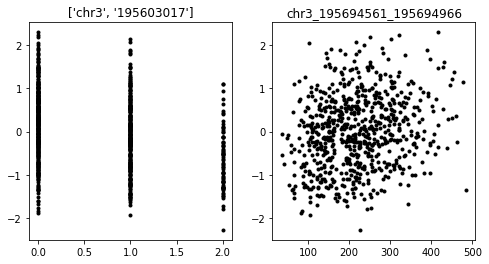

Muscle_Skeletal lead SNP chr3_195940467_G_A_b38 for ENSG00000215837.7 not within 100kb range
ENSG00000283426.1


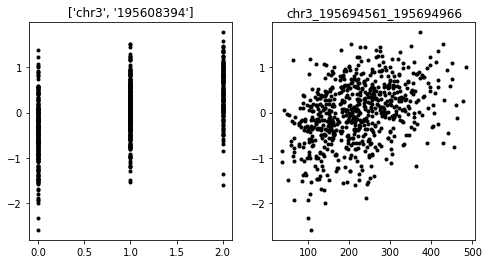

ENSG00000185619.18


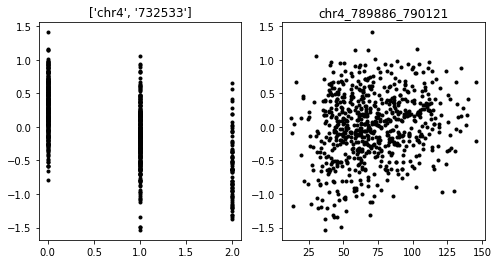

ENSG00000138744.14


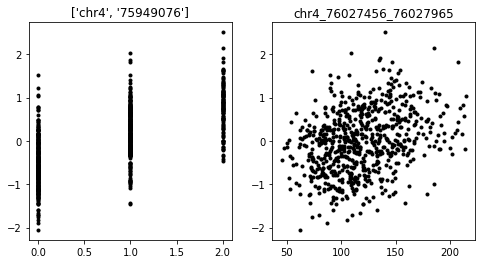

ENSG00000138750.14


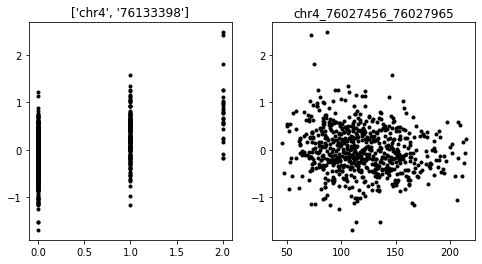

ENSG00000206077.10


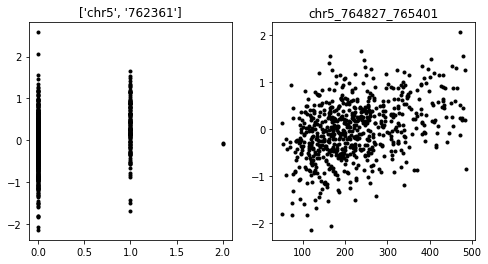

ENSG00000249908.2


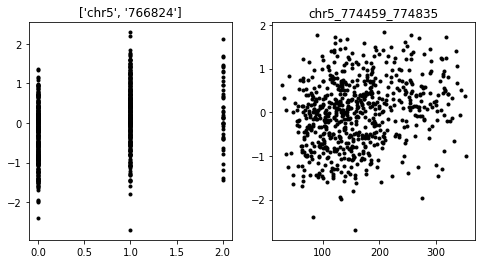

ENSG00000188818.12


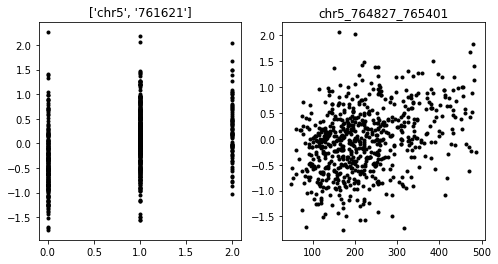

ENSG00000197226.12


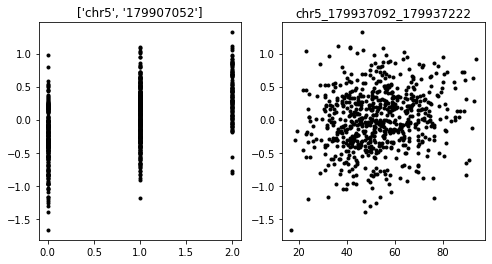

ENSG00000124532.14


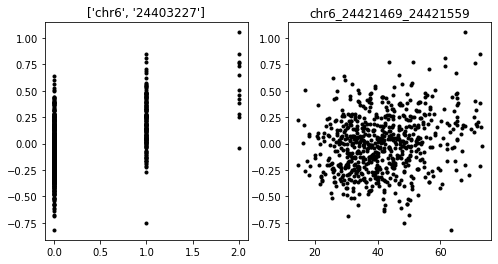

ENSG00000158691.14


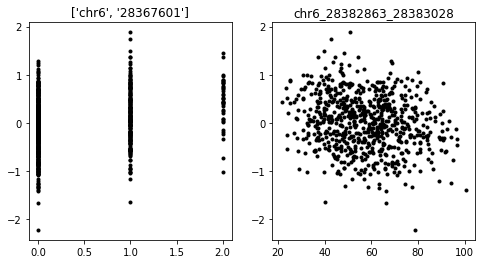

ENSG00000187987.9


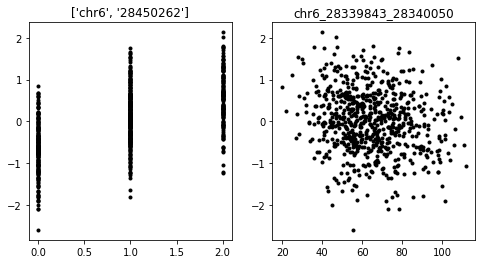

ENSG00000164393.8


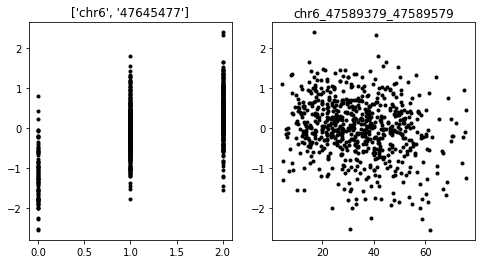

ENSG00000153294.11


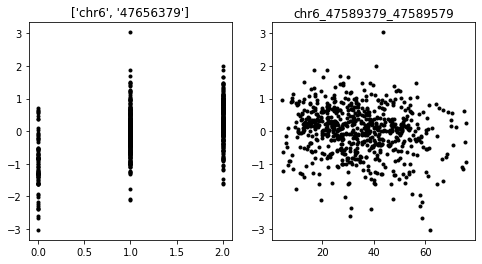

ENSG00000164465.18


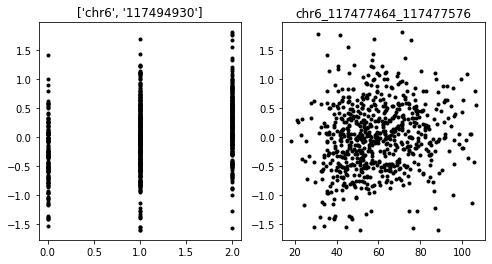

ENSG00000273100.1


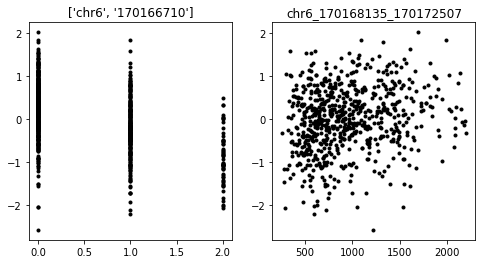

ENSG00000183696.13


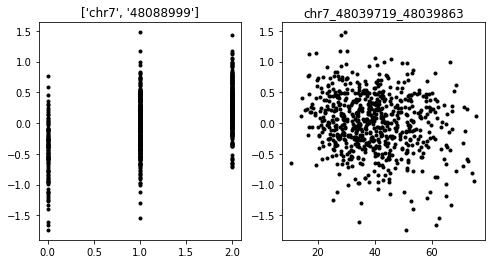

ENSG00000165171.10


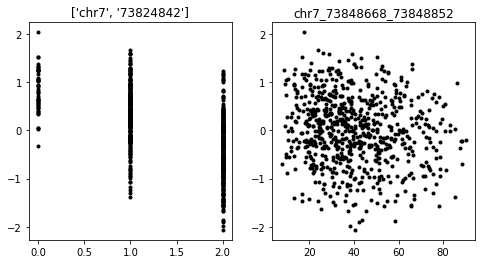

ENSG00000230715.3


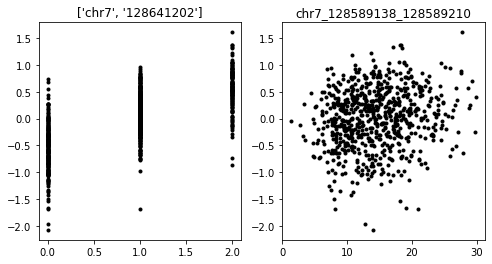

ENSG00000243679.1


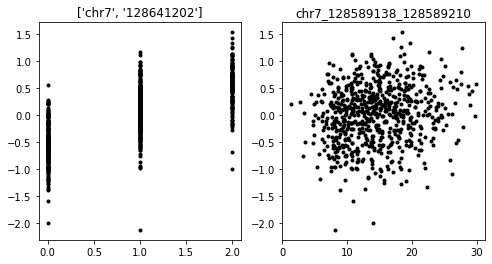

ENSG00000254812.1


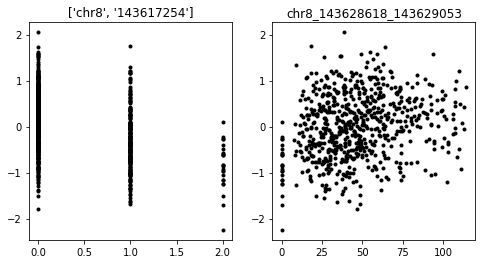

ENSG00000215237.6


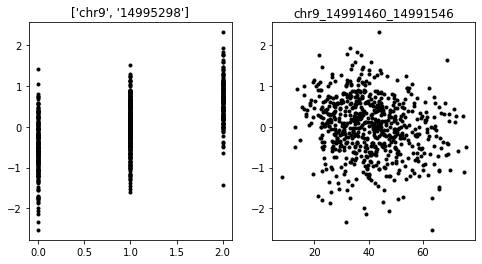

Muscle_Skeletal lead SNP chr9_41928396_C_T_b38 for ENSG00000276291.5 not within 100kb range
ENSG00000275160.1


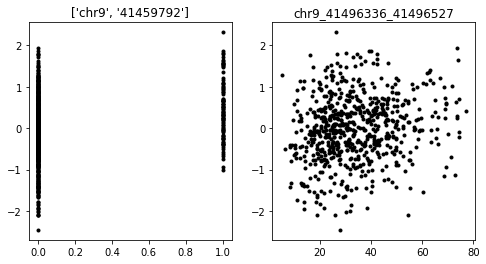

ENSG00000151468.10


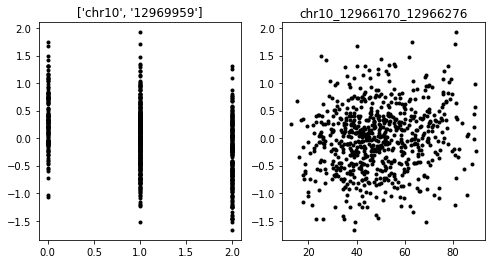

ENSG00000151640.12


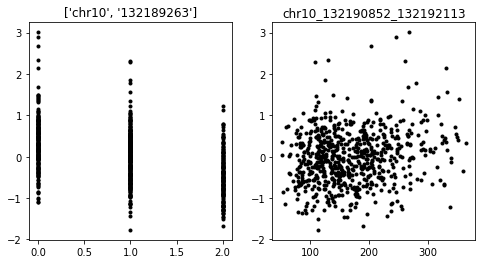

ENSG00000148824.18


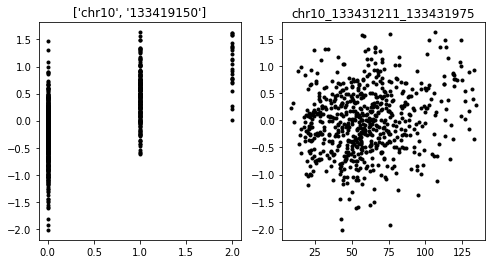

ENSG00000174775.16


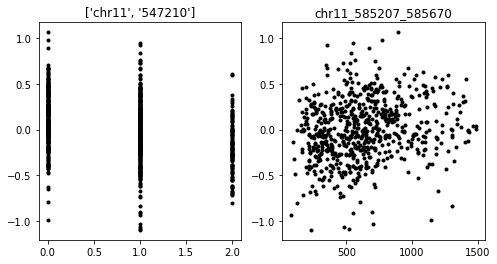

ENSG00000129744.2


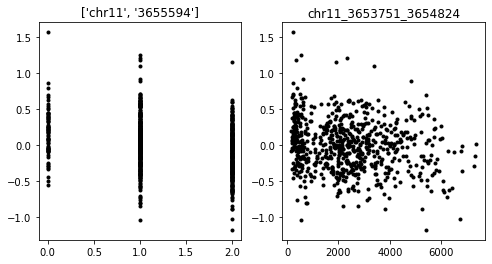

ENSG00000129749.3


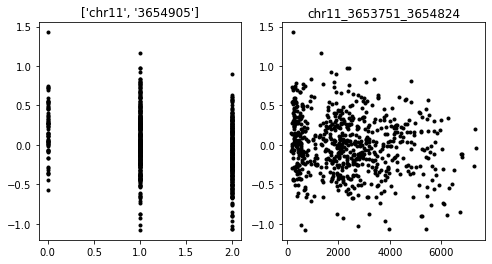

ENSG00000184967.6


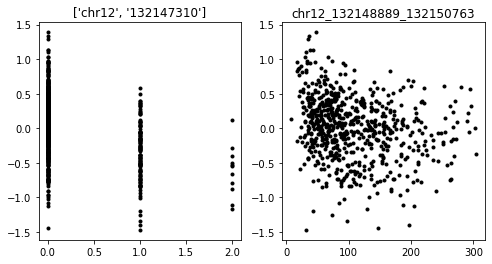

ENSG00000032742.17


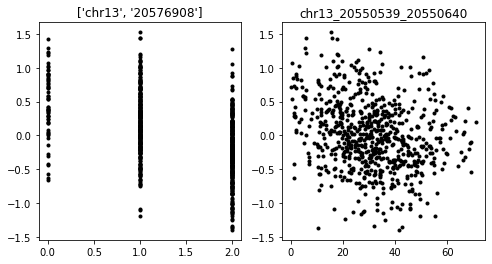

ENSG00000150403.17


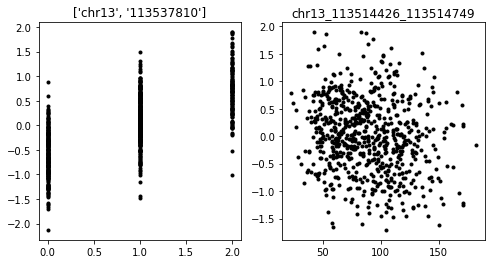

ENSG00000248508.6


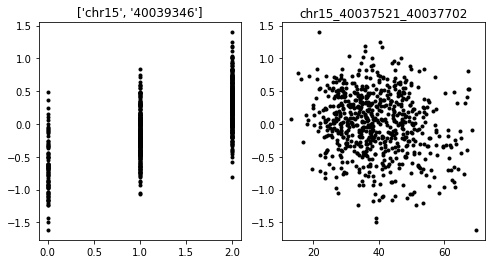

ENSG00000182397.14


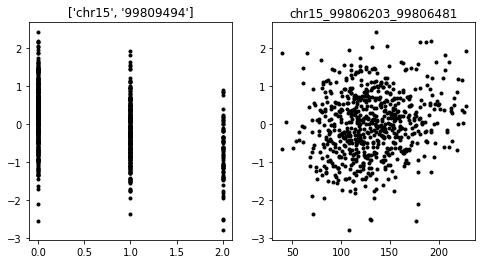

ENSG00000270127.2


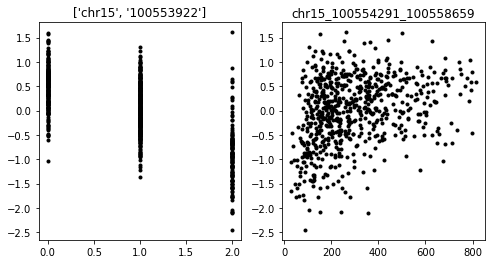

ENSG00000259205.2


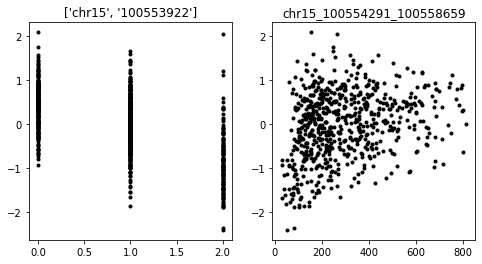

ENSG00000103227.18


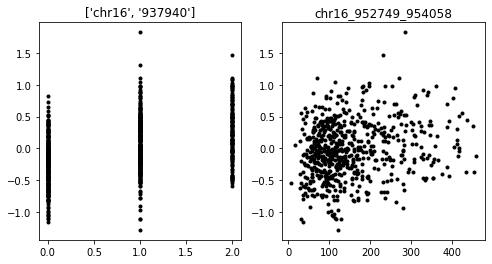

ENSG00000166669.13


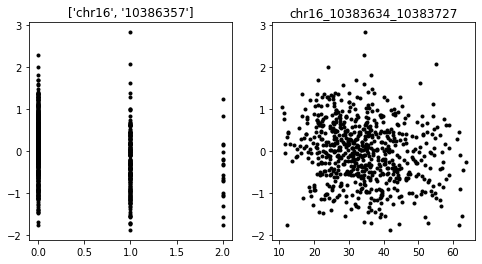

ENSG00000274627.1


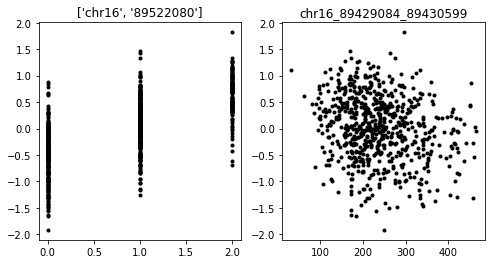

ENSG00000167711.13


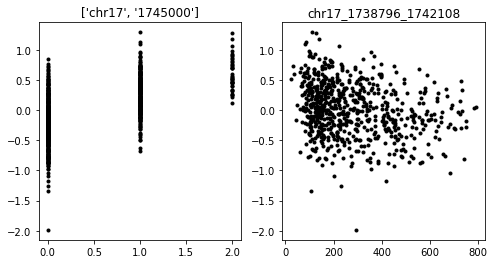

ENSG00000278845.4


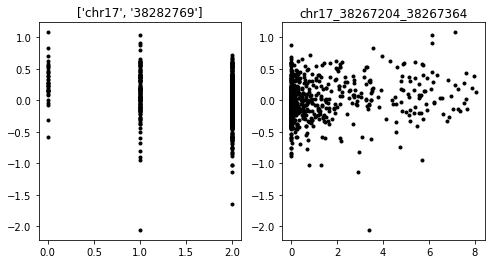

Muscle_Skeletal lead SNP chr17_45587535_T_A_b38 for ENSG00000214401.4 not within 100kb range
ENSG00000120071.13


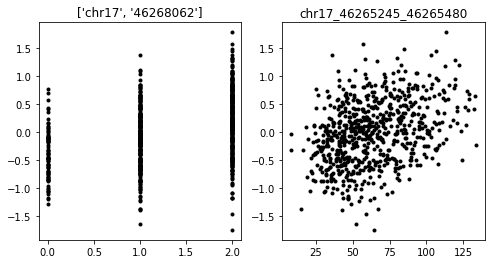

Muscle_Skeletal lead SNP chr17_45587535_T_A_b38 for ENSG00000262539.1 not within 100kb range
ENSG00000261575.2


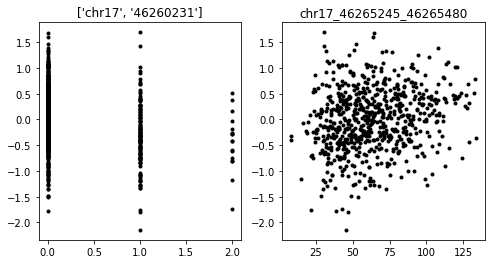

ENSG00000141564.13


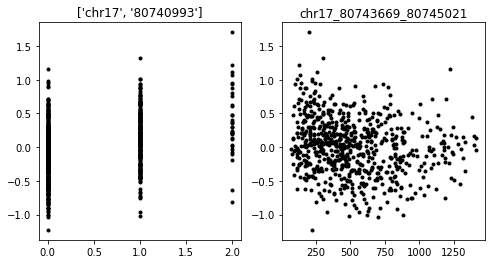

ENSG00000171903.16


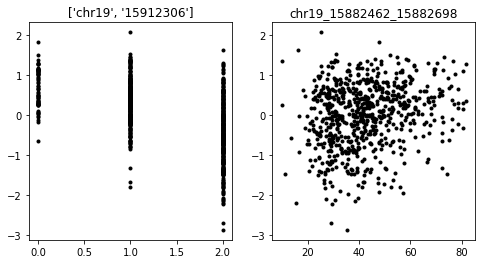

ENSG00000127220.5


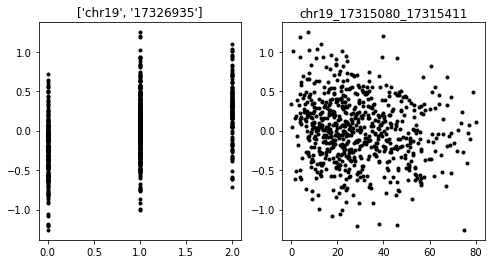

ENSG00000268362.5


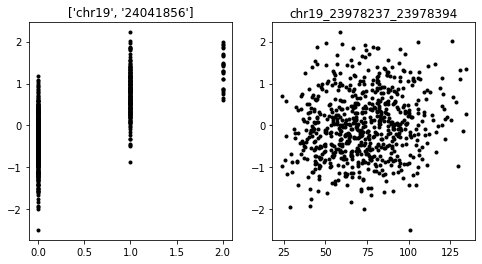

ENSG00000204673.10


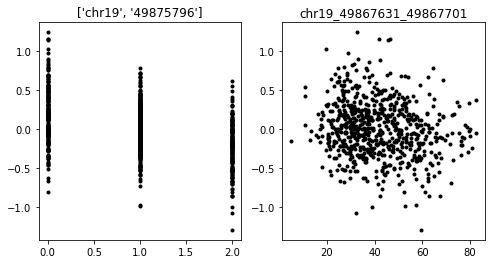

ENSG00000215305.9


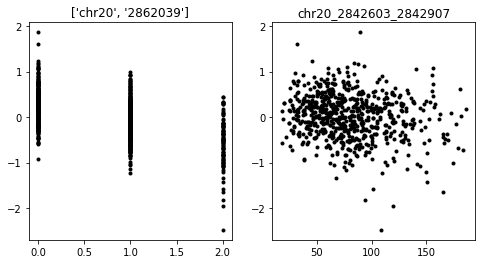

ENSG00000131067.16


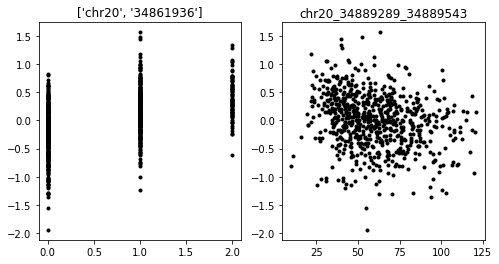

ENSG00000124116.18


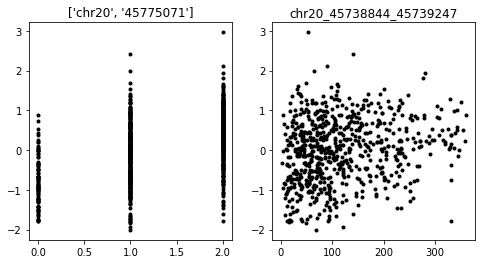

ENSG00000101457.12


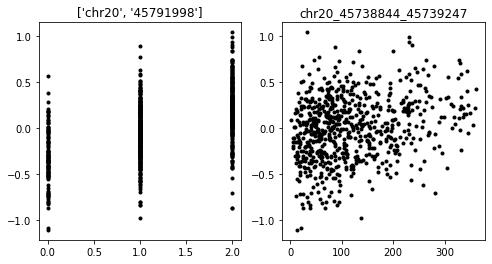

ENSG00000241945.7


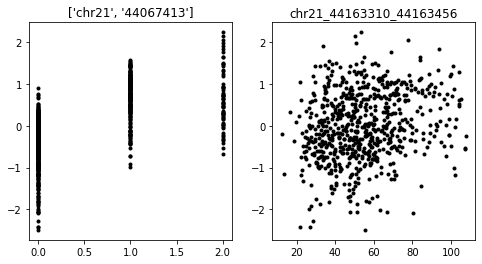

ENSG00000160221.16


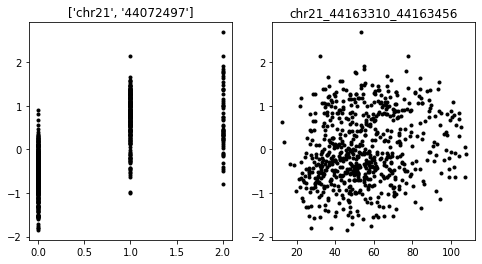

ENSG00000182362.13


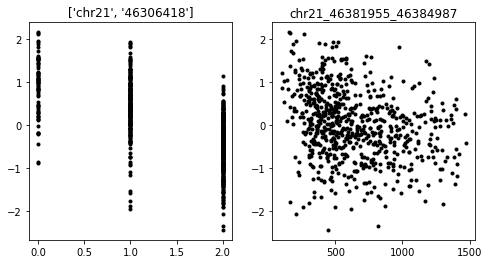

ENSG00000234630.1


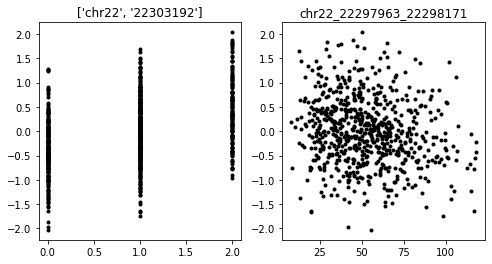

ENSG00000272779.1


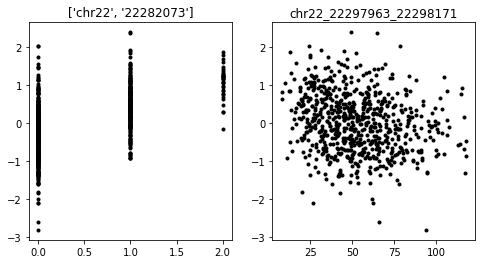

ENSG00000100058.12


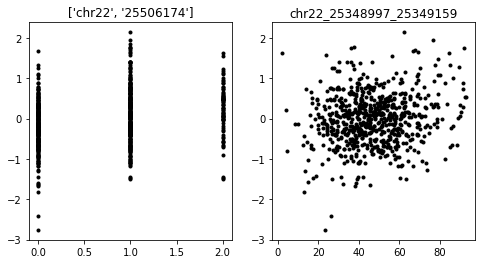

ENSG00000272977.1


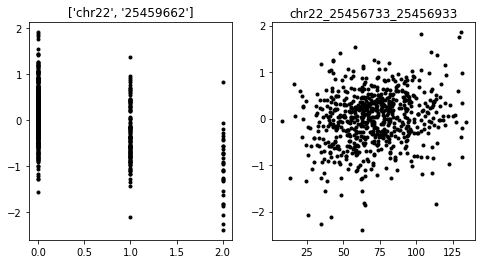

ENSG00000228274.3


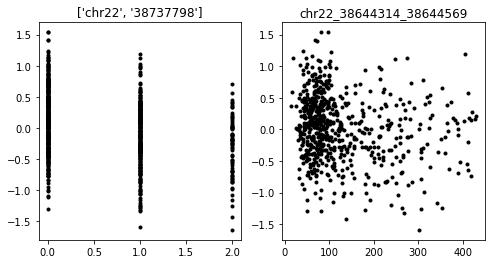

ENSG00000189306.10


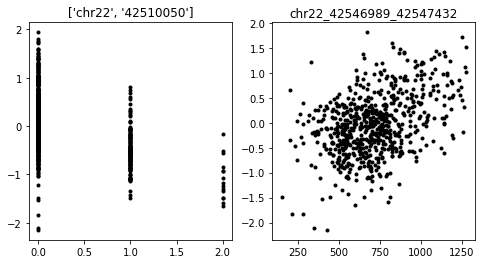

ENSG00000278869.1


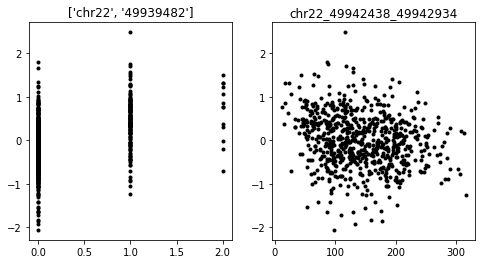

ENSG00000018610.13


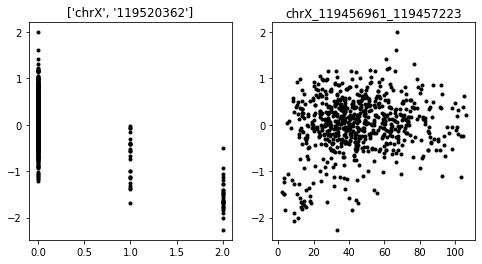

In [22]:
smask = loadSampleMask() # sample mask, 838

In [5]:
def test():
    import numpy as np
    tissue = "Whole_Blood"
    tmp = np.loadtxt(f"/scratch2/tsungyul/pm570/input/{tissue}.genelist.txt", dtype=object)
    print(tmp.shape)
    tisGene2ind = {}
    for ind, gene in enumerate(tmp):
        tisGene2ind[gene] = ind   
    print("indexing done")
test()

(20315,)
indexing done
